# WINE QUALITY DATASET

Este notebook forma parte del proyecto **PC1: Análisis de Calidad de Vinos**, cuyo objetivo es analizar las características que determinan la calidad de los vinos tintos y blancos utilizando el [Wine Quality Dataset](http://archive.ics.uci.edu/dataset/186/wine+quality).

### **Objetivo de este notebook**
En este notebook se llevarán a cabo los siguientes pasos:
1. Descargar programáticamente los datasets de vinos tintos y blancos desde el repositorio oficial y asegurarse de que estén disponibles en el entorno de trabajo como archivos CSV.
2. Combinar los datasets en un único dataframe, añadiendo una columna que indique el tipo de vino (`red` o `white`), y verificar la cantidad de registros y las variables disponibles.
3. Realizar un análisis estadístico o inspección visual de cada columna numérica para identificar y manejar valores atípicos y ausentes.
4. Almacenar los datos limpios en una base de datos SQLite para garantizar persistencia y eficiencia.
5. Realizar consultas SQL sobre los datos almacenados, incluyendo:
   - El promedio de calidad (`quality`) por tipo de vino (`type`).
   - El conteo de vinos con nivel de alcohol superior a 10.5, agrupados por tipo.
   - El conteo de vinos por nivel de acidez (`fixed acidity`), agrupados en rangos específicos.
6. Exportar los resultados de una consulta seleccionada en formato JSONLines para su potencial uso en una base de datos noSQL como MongoDB.
7. Inspeccionar las características de los vinos tintos y blancos de mayor calidad (`quality`) utilizando técnicas estadísticas y gráficas.

## 1.1 Configuración del entorno

Este notebook utiliza las dependencias definidas en el archivo `requirements.txt`.
El entorno virtual asociado es `PC1`. Asegúrate de que esté activado antes de ejecutar este notebook.

In [1]:
#!python --version
#!pip list

In [2]:
# Mostrar el contenido del archivo requirements.txt
with open("../requirements.txt", "r") as f:
    print(f.read())

#
# This file is autogenerated by pip-compile with Python 3.13
# by the following command:
#
#    pip-compile requirements.in
#
attrs==25.1.0
    # via
    #   jsonlines
    #   outcome
    #   trio
beautifulsoup4==4.13.3
    # via bs4
bs4==0.0.2
    # via -r requirements.in
certifi==2025.1.31
    # via
    #   requests
    #   selenium
cffi==1.17.1
    # via trio
charset-normalizer==3.4.1
    # via requests
contourpy==1.3.1
    # via matplotlib
cycler==0.12.1
    # via matplotlib
fonttools==4.55.3
    # via matplotlib
h11==0.14.0
    # via wsproto
idna==3.10
    # via
    #   requests
    #   trio
joblib==1.4.2
    # via scikit-learn
jsonlines==4.0.0
    # via -r requirements.in
kiwisolver==1.4.8
    # via matplotlib
matplotlib==3.10.0
    # via
    #   -r requirements.in
    #   seaborn
numpy==2.2.1
    # via
    #   -r requirements.in
    #   contourpy
    #   matplotlib
    #   pandas
    #   scikit-learn
    #   scipy
    #   seaborn
outcome==1.3.0.post0
    # via
    #   trio
   

## 1.2 Descarga de los datasets

**Opciones para acceder al dataset**

(`Enlace directo`): Se creó la carpeta data para descargar los datos manualmente desde las URLs del repositorio UCI. Sin embargo, si los datos son actualizados en el repositorio, no se sincronizan automáticamente.

(`Librería ucimlrepo`): Automatiza la descarga y carga de datos como DataFrames, incluyendo metadatos. Requiere instalar una librería adicional.

(`Repositorio GitHub`): Clona el repositorio completo de UCI para explorar múltiples datasets. Útil para trabajos más amplios, pero menos específico.

(`Usando WebScrapping`): A través de selenium se descargarán los datasets sin necesidad de entrar en el enlace 

Dado que los datasets descargados manualmente incluyen explícitamente la diferenciación entre vinos tintos y blancos en archivos separados (winequality-red.csv y winequality-white.csv), se utilizarán estos archivos para realizar la combinación de datos. Pero los descargaremos usando webScrapping

Aunque la librería ucimlrepo organiza los datos en un formato estándar, no proporciona información explícita para diferenciar entre vinos tintos y blancos. Este análisis será abordado como un ejercicio extra al final del proyecto, donde se intentará identificar las diferencias entre ambos tipos de vino basándonos en características fisicoquímicas

El dataset se encuentra en una carpeta zip en la URL proporcionada.

Se carga Selenium para acceder al dataset a traves de XPATH

In [3]:
'''
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from time import sleep
import requests
from bs4 import BeautifulSoup

# Ruta al ChromeDriver
service = Service(executable_path="C:/Users/Oscar/Documents/MBIT_Oscar/Ruta_Selenium/chromedriver-win64/chromedriver.exe")

# Opciones para Chrome
options = webdriver.ChromeOptions()
options.add_argument('--incognito')

# Iniciar el navegador
driver = webdriver.Chrome(service=service, options=options)
driver.get("http://archive.ics.uci.edu/dataset/186/wine+quality")
'''

'\nfrom selenium import webdriver\nfrom selenium.webdriver.common.by import By\nfrom selenium.webdriver.chrome.service import Service\nfrom time import sleep\nimport requests\nfrom bs4 import BeautifulSoup\n\n# Ruta al ChromeDriver\nservice = Service(executable_path="C:/Users/Oscar/Documents/MBIT_Oscar/Ruta_Selenium/chromedriver-win64/chromedriver.exe")\n\n# Opciones para Chrome\noptions = webdriver.ChromeOptions()\noptions.add_argument(\'--incognito\')\n\n# Iniciar el navegador\ndriver = webdriver.Chrome(service=service, options=options)\ndriver.get("http://archive.ics.uci.edu/dataset/186/wine+quality")\n'

In [4]:
'''
dataset_download = driver.find_element(By.XPATH, "/html/body/div[1]/div[1]/div[1]/main/div/div[2]/div[1]/a")
dataset_download.click()

# Esperar un poco para que la descarga termine
sleep(5)

driver.close()
# este paso descarga el archivo ZIP que contiene ambos datasets en la carpeta Downloads de Windows.
'''

'\ndataset_download = driver.find_element(By.XPATH, "/html/body/div[1]/div[1]/div[1]/main/div/div[2]/div[1]/a")\ndataset_download.click()\n\n# Esperar un poco para que la descarga termine\nsleep(5)\n\ndriver.close()\n# este paso descarga el archivo ZIP que contiene ambos datasets en la carpeta Downloads de Windows.\n'

In [5]:
'''
import os
import zipfile
from zipfile import ZipFile 

#  Ruta de descarga en la carpeta Downloads
download_folder = "C:/Users/Oscar/Downloads"
zip_filename = "wine+quality.zip"
zip_filepath = os.path.join(download_folder, zip_filename)

# Directorio donde queremos guardar los archivos extraídos
destination_folder = "C:/Users/Oscar/Documents/MBIT_Oscar/MBIT_202501_Proyecto_Consolidacion_1/data"

# Verificar si el archivo ZIP existe antes de continuar
if os.path.exists(zip_filepath):
    print(f"Archivo ZIP encontrado: {zip_filepath}")

    # Extraer el contenido
    with ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)
        print(f"Archivos extraídos en {destination_folder}")

    # Mover el archivo ZIP a la carpeta de datos para almacenamiento (opcional)
    shutil.move(zip_filepath, os.path.join(destination_folder, zip_filename))
    print(f"Archivo ZIP movido a {destination_folder}")

else:
    print(" No se encontró el archivo ZIP en la carpeta Downloads. Verifica que se haya descargado correctamente.")
'''

'\nimport os\nimport zipfile\nfrom zipfile import ZipFile \n\n#  Ruta de descarga en la carpeta Downloads\ndownload_folder = "C:/Users/Oscar/Downloads"\nzip_filename = "wine+quality.zip"\nzip_filepath = os.path.join(download_folder, zip_filename)\n\n# Directorio donde queremos guardar los archivos extraídos\ndestination_folder = "C:/Users/Oscar/Documents/MBIT_Oscar/MBIT_202501_Proyecto_Consolidacion_1/data"\n\n# Verificar si el archivo ZIP existe antes de continuar\nif os.path.exists(zip_filepath):\n    print(f"Archivo ZIP encontrado: {zip_filepath}")\n\n    # Extraer el contenido\n    with ZipFile(zip_filepath, \'r\') as zip_ref:\n        zip_ref.extractall(destination_folder)\n        print(f"Archivos extraídos en {destination_folder}")\n\n    # Mover el archivo ZIP a la carpeta de datos para almacenamiento (opcional)\n    shutil.move(zip_filepath, os.path.join(destination_folder, zip_filename))\n    print(f"Archivo ZIP movido a {destination_folder}")\n\nelse:\n    print(" No se enco

---
Para evitar problemas el dataset ya se encontrará descargado pero se describe arriba como se puede descargar automáticamente usando webscrapping

# 2. Combinar los datos

En este paso se combinarán los datasets de vinos tintos y blancos en un único DataFrame. Se añadirá una columna adicional que indique el tipo de vino (red o white) para diferenciarlos. Además, se analizará la cantidad total de registros y las variables disponibles, identificando sus tipos y características.

In [6]:
import pandas as pd

In [7]:
#leemos los datasets, utilizamos el sep ; ya que en el dataset viene separado por ;
df_red_wine = pd.read_csv('../data/winequality-red.csv', sep = ';')
df_white_wine = pd.read_csv('../data/winequality-white.csv', sep = ';')

In [8]:
#Primero pediremos información de los datasets
df_red_wine.info()
df_white_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column        

Como podemos comprobar las columnas están separadas por ; por lo que procederemos a realizar una limpieza y preparación de datos

Esto nos indica que no hay valores nulos

In [9]:
#Crearemos la coumna type-wine para clasificar los que son tintos y blancos para después combinarlos
df_red_wine['type-wine'] = 'red'
df_white_wine['type-wine'] = 'white'

In [10]:
# checkeamos que se ha creado
df_white_wine.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type-wine
3303,6.3,0.22,0.34,5.00,0.032,36.0,93.0,0.99012,3.27,0.36,13.5,7,white
4054,7.2,0.17,0.28,17.55,0.050,33.0,154.0,0.99971,2.94,0.43,9.0,7,white
2164,8.4,0.22,0.28,18.80,0.028,55.0,130.0,0.99800,2.96,0.35,11.6,5,white
399,6.4,0.19,0.42,2.90,0.032,32.0,83.0,0.99080,3.30,0.41,11.7,6,white
3252,7.1,0.26,0.37,5.50,0.025,31.0,105.0,0.99082,3.06,0.33,12.6,8,white


In [11]:
#Ahora combinamos los dos dataframes
df_wine_quality = pd.concat([df_red_wine, df_white_wine])
df_wine_quality.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type-wine
926,9.4,0.24,0.33,2.3,0.061,52.0,73.0,0.99786,3.47,0.90,10.2,6,red
1749,6.1,0.17,0.27,1.5,0.056,45.0,135.0,0.99240,3.20,0.43,10.2,6,white
1328,5.2,0.37,0.33,1.2,0.028,13.0,81.0,0.99020,3.37,0.38,11.7,6,white
631,10.4,0.28,0.54,2.7,0.105,5.0,19.0,0.99880,3.25,0.63,9.5,5,red
184,6.8,0.26,0.56,11.9,0.043,64.0,226.0,0.99700,3.02,0.63,9.3,5,white


In [12]:
df_wine_quality.info()
df_wine_quality.shape
# Comprobamos las columnas, nº de datos y tipo de datos

<class 'pandas.core.frame.DataFrame'>
Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type-wine             6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 710.6+ KB


(6497, 13)

In [13]:
df_wine_quality.columns # comprobamos que en las columnas no existen espacios en blanco antes o después de las comillas

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'type-wine'],
      dtype='object')

In [14]:
df_wine_quality.describe() # realizamos un informe estadístico

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


# 3. Filtramos los atípicos y manejar los ausentes

Hasta este punto, hemos descargado, limpiado y combinado los datasets de vinos tintos y blancos en un único DataFrame. También hemos realizado una inspección inicial de las características de los datos, verificando su estructura, valores nulos y estadísticas descriptivas.
Para continuar con el análisis exploratorio, es fundamental detectar la presencia de valores atípicos (outliers) en las variables numéricas y evaluar la distribución de los datos. Esto nos ayudará a comprender mejor la variabilidad de los datos y tomar decisiones sobre el preprocesamiento antes de aplicar modelos predictivos.


## Detección de Outliers con Boxplot
El boxplot es una herramienta visual que nos permite detectar valores atípicos dentro de cada variable. Se basa en los cuartiles y los bigotes para identificar puntos que están considerablemente alejados de la distribución central de los datos. Los valores atípicos pueden ser el resultado de errores de medición, datos mal ingresados o simplemente fenómenos extremos dentro de la distribución.

¿Por qué es importante detectar outliers?

- Pueden afectar la precisión de los modelos predictivos.
- Influyen en el cálculo de la media y la varianza.
- En algunos casos, pueden proporcionar información relevante sobre variaciones extremas en la calidad del vino.

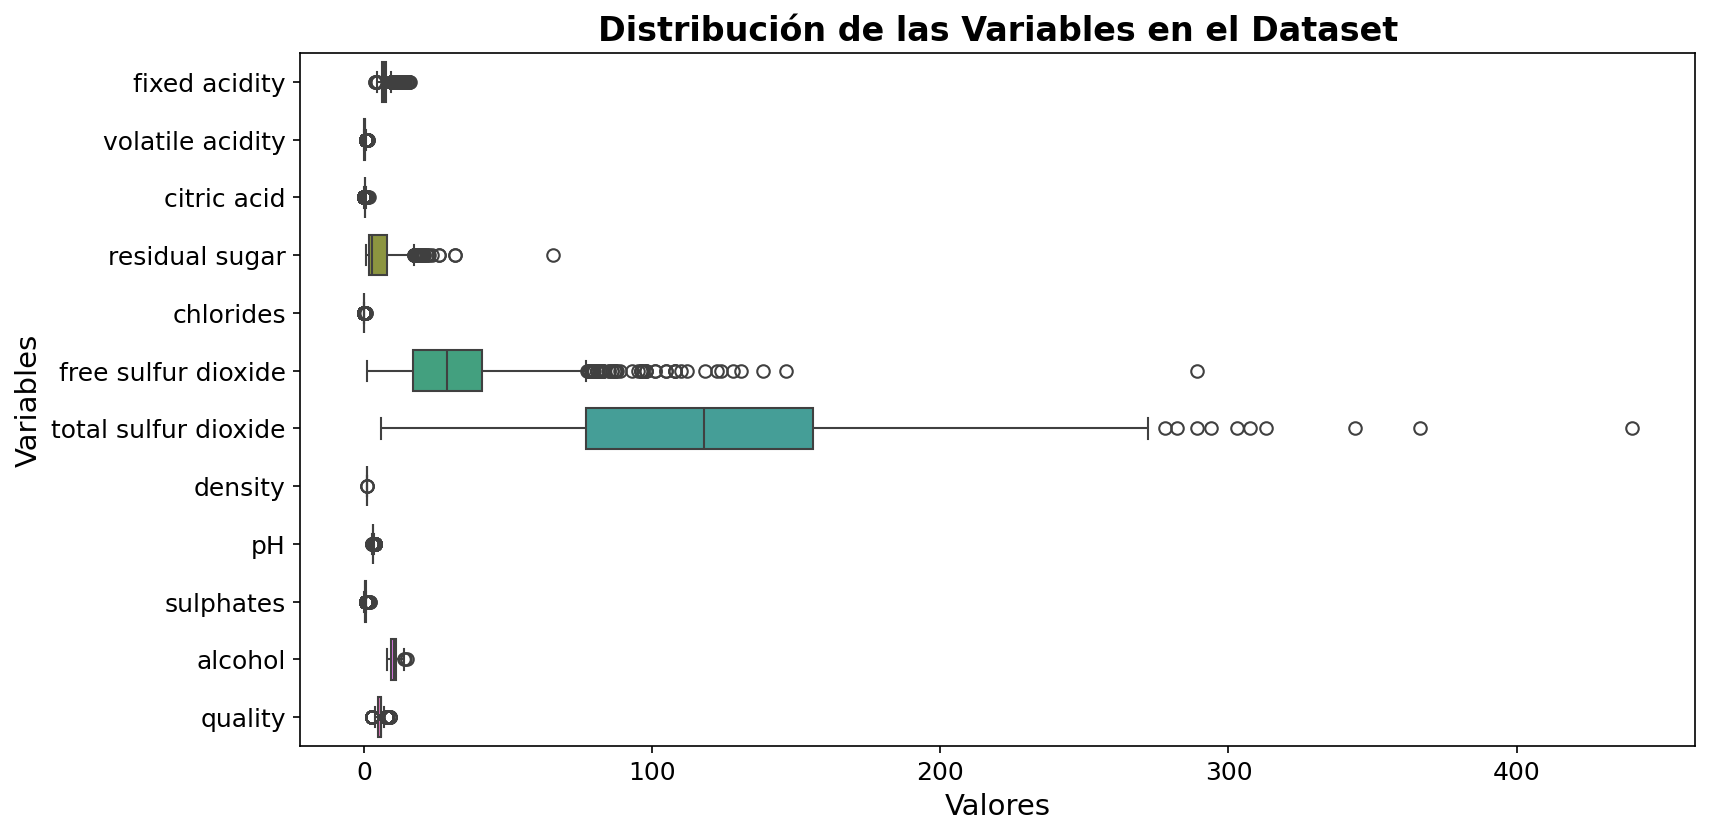

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir tamaño de figura y DPI alto
plt.figure(figsize=(12, 6), dpi=150)

# Crearemos el boxplot
sns.boxplot(data=df_wine_quality, orient='h', width=0.7)

# Personalizar estilo y ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Valores", fontsize=14)
plt.ylabel("Variables", fontsize=14)
plt.title("Distribución de las Variables en el Dataset", fontsize=16, fontweight="bold")

# Mostraremos la gráfica
plt.show()


## Análisis de Distribución: Normalidad de los Datos
Después de detectar los **valores atípicos**, analizaremos si los datos siguen una **distribución de los datos** utilizando **histogramas** y **curvas KDE (Kernel Density Estimation)**. La normalidad es un supuesto fundamental en muchas técnicas estadísticas y de Machine Learning, ya que:

¿Por qué queremos verificar la distribución normal de los datos?

- Si los datos son **normales**, algunos modelos como `regresión lineal o ANOVA` pueden aplicarse directamente sin transformaciones adicionales.
- Si los datos **no son normales**, puede ser necesario aplicar técnicas como `escalado logarítmico, Box-Cox o estandarización` para mejorar el rendimiento de ciertos modelos.
- La normalidad nos permite interpretar mejor las métricas de dispersión como la desviación estándar y la media.

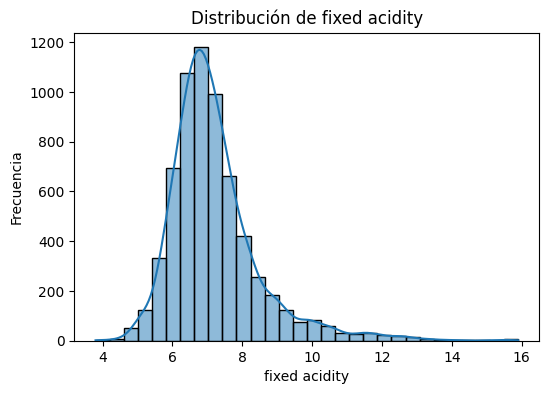

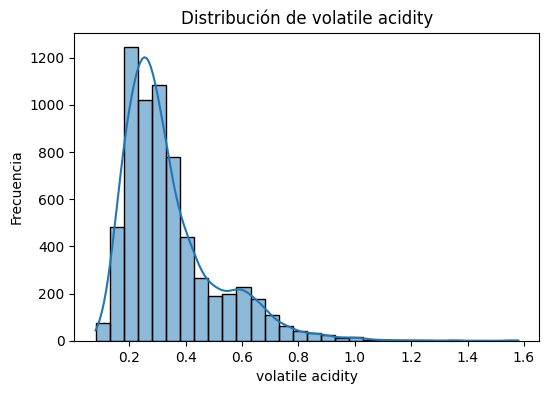

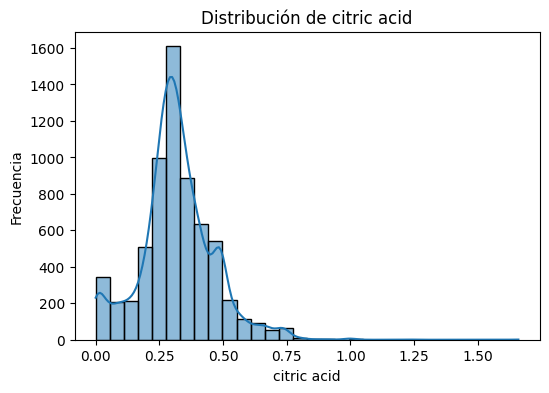

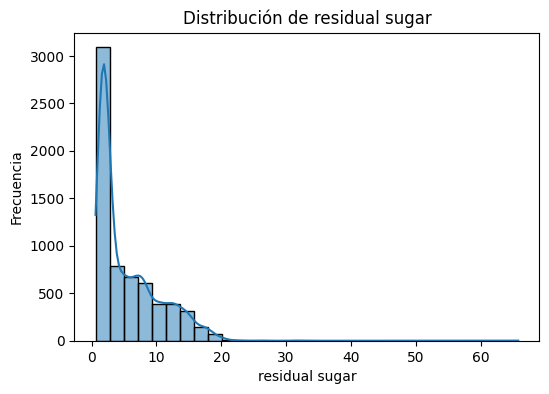

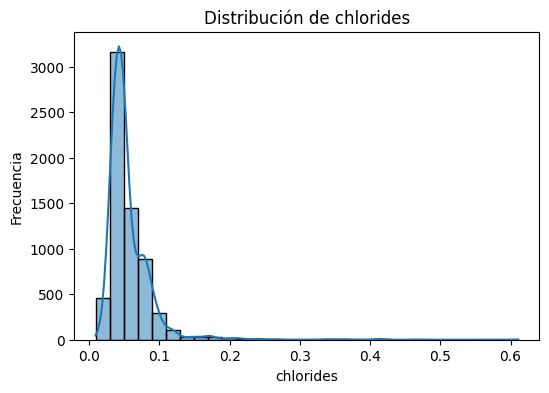

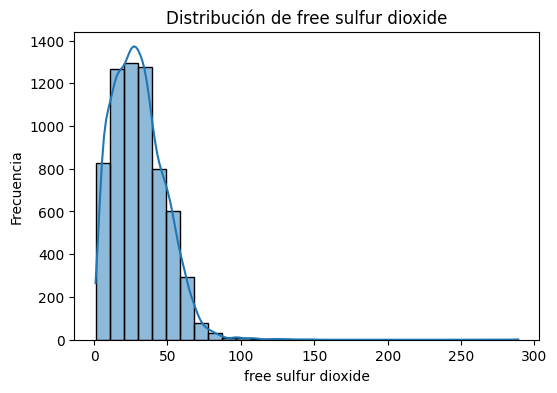

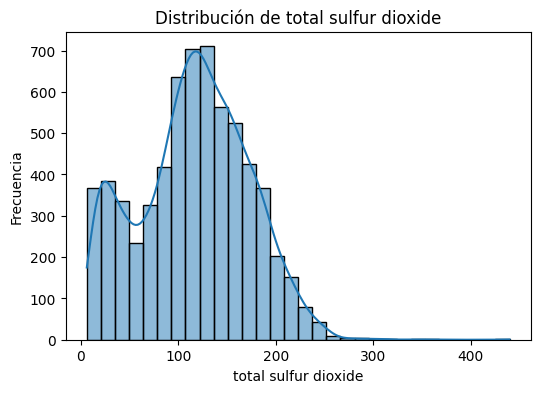

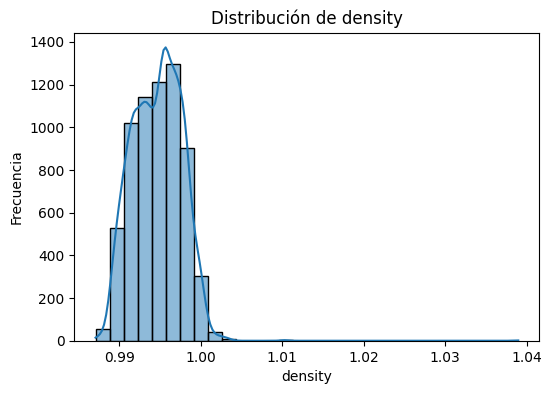

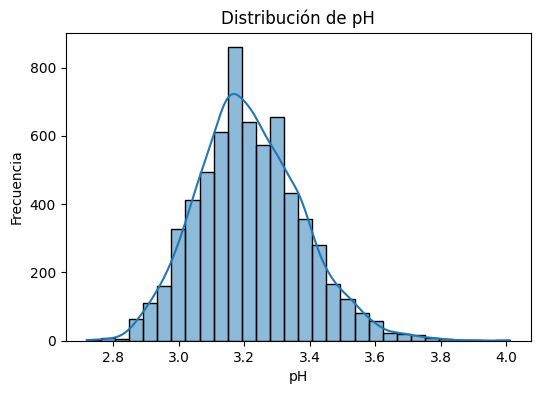

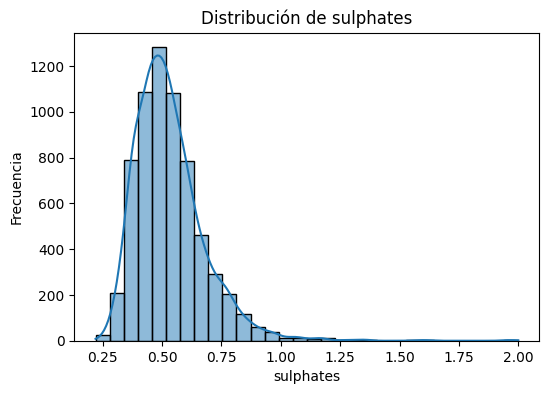

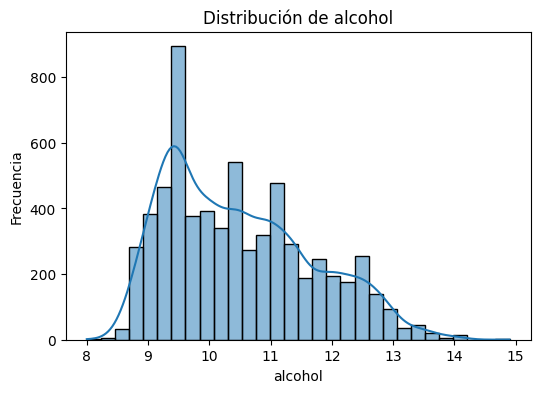

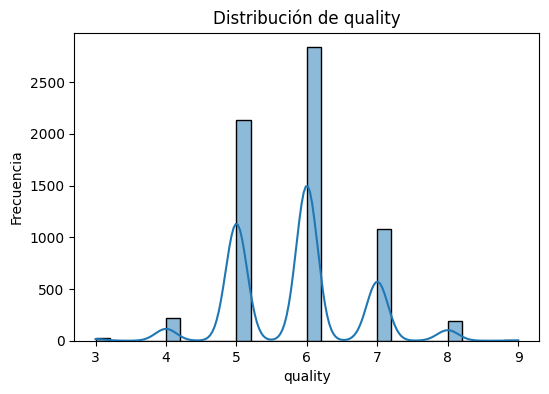

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de columnas numéricas (excluyendo 'type-wine' porque es categórica)
numeric_columns = df_wine_quality.select_dtypes(include=['float64', 'int64']).columns

# Graficar histogramas de todas las columnas numéricas
for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_wine_quality[col], bins=30, kde=True)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

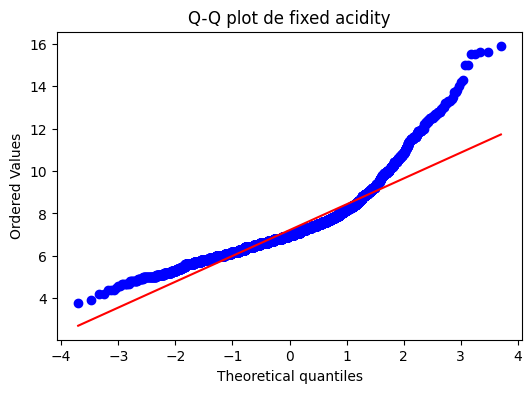

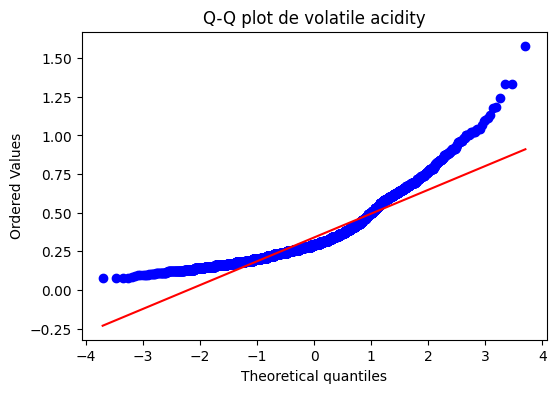

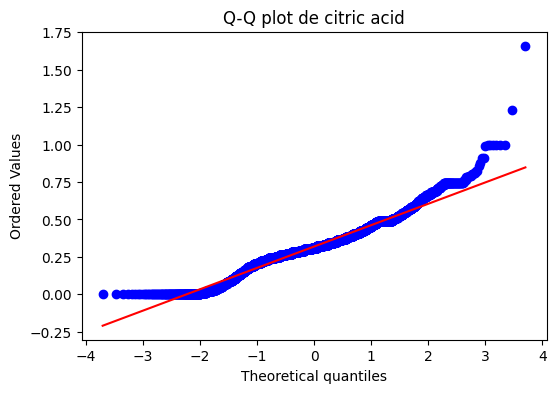

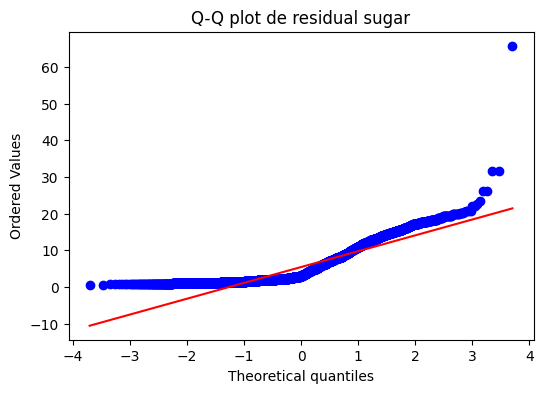

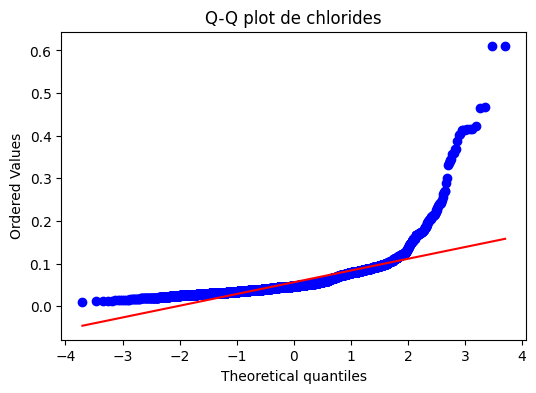

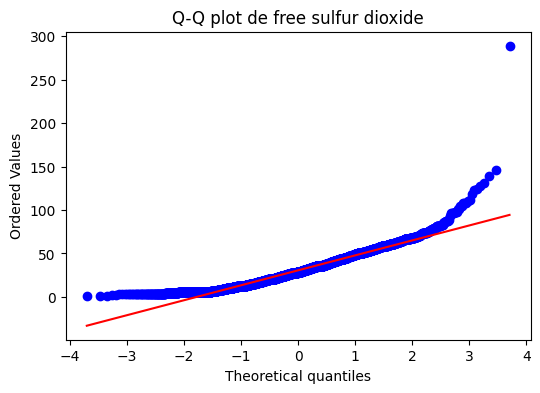

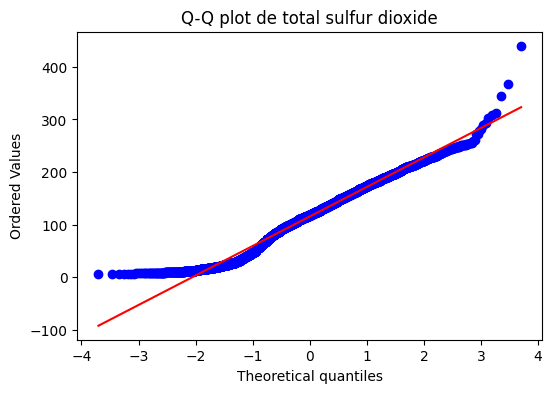

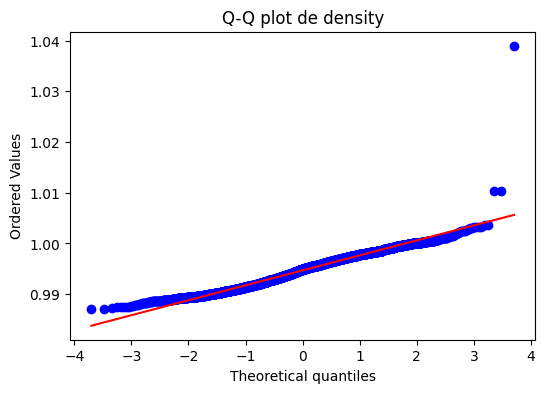

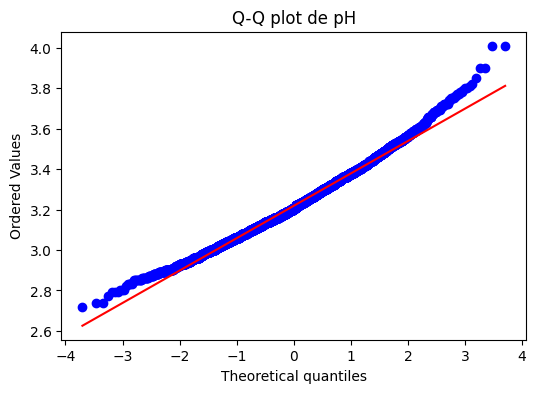

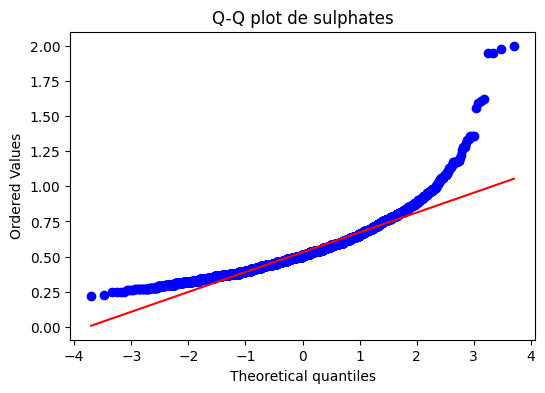

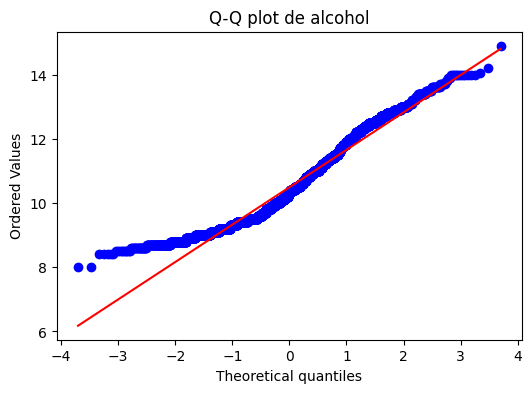

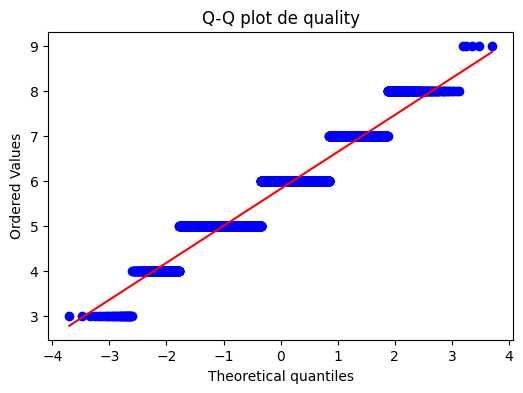

In [17]:
import scipy.stats as stats

# Generar Q-Q plots para todas las columnas numéricas
for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    stats.probplot(df_wine_quality[col], dist="norm", plot=plt)
    plt.title(f"Q-Q plot de {col}")
    plt.show()

## Conclusión del Análisis Exploratorio
A partir del boxplot, observamos la presencia de varios valores atípicos (outliers) en múltiples variables. En particular, se pueden identificar valores extremos en características como `free sulfur dioxide` y `total sulfur dioxide`, lo cual indica que algunos vinos tienen concentraciones excepcionalmente altas de estos compuestos en comparación con el resto de la muestra.

Por otro lado, al analizar la distribución de los datos mediante histogramas, encontramos que la mayoría de las variables no siguen una distribución normal, sino que presentan una asimetría positiva (cola a la derecha). Esto sugiere que los valores altos son menos frecuentes y que una parte significativa de los datos se concentra en valores más bajos. Sin embargo, una excepción notable es el `pH` y la `densidad`, que sigue una distribución aproximadamente normal.


## Tratamiento de Valores Atípicos: Métodos IQR y Six Sigma
Al observar el boxplot, hemos identificado la presencia de valores atípicos en varias variables del dataset. Para asegurar que nuestro análisis y modelo sean robustos, procederemos con el tratamiento de estos valores utilizando dos técnicas comúnmente empleadas en la ciencia de datos.

Dado que nuestros datos **no siguen una distribución normal**, el método **IQR (Rango Intercuartílico)** es la opción más adecuada para tratar los valores atípicos. Esto se debe a que:

`IQR es un método robusto`, basado en los cuartiles, lo que lo hace menos sensible a la presencia de valores extremos en la distribución.  
`Six Sigma se basa en la desviación estándar`, una métrica que puede verse significativamente afectada por distribuciones no normales y la presencia de valores atípicos, lo que lo hace menos confiable en este contexto.  

Por lo tanto, utilizaremos **IQR para filtrar los valores atípicos** de manera más efectiva y sin comprometer la integridad del conjunto de datos. 

In [18]:
#Antes de empezar a hacer un tratamiento de datos realizaremos una copia sobre la que trabajar
df_wine_clean = df_wine_quality.copy()

### Método 1: Rango Intercuartil (IQR – Interquartile Range)
El `IQR (Interquartile Range)` es una técnica basada en la estadística descriptiva que nos permite detectar y eliminar valores extremos en una distribución. Se basa en los percentiles Q1 (25%) y Q3 (75%) de los datos.

### ¿Cómo funciona el IQR?
1. Calculamos Q1 (percentil 25%) y Q3 (percentil 75%).
2. Calculamos el rango intercuartil (IQR) con la fórmula:
IQR=Q3−Q1
3. Definimos los límites superior e inferior:
    - Límite inferior: Q1−1.5×IQR
    - Límite superior: Q3+1.5×IQR
      
4. Los valores fuera de estos límites se consideran atípicos. Podemos eliminarlos o transformarlos.
   
   Ventajas:
    - Fácil de interpretar.
    - No asume que los datos siguen una distribución normal.
    - Es ideal para datos con distribuciones sesgadas.

    Desventajas:
    - Puede eliminar datos válidos si la distribución es naturalmente dispersa.
    - No es adecuado para detectar atípicos en distribuciones normales con grandes variaciones.

In [19]:
# Seleccionamos las columnas numéricas
numeric_columns = df_wine_clean.select_dtypes(include=['float64', 'int64'])

# Calcular Q1 y Q3
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)

# Calcular IQR
IQR = Q3 - Q1

# Calcularemos el límites inferior y superior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [20]:
# Crearemos un nuevo DataFrame con estas estadísticas
iqr_summary = pd.DataFrame({
    "Q1 (25%)": Q1,
    "Q3 (75%)": Q3,
    "IQR": IQR,
    "Limite_Inferior": lower_bound,
    "Limite_Superior": upper_bound
})
#Mostramos los valores obtenidos
iqr_summary

,Q1 (25%),Q3 (75%),IQR,Limite_Inferior,Limite_Superior
fixed acidity,6.40000,7.70000,1.30000,4.450000,9.650000
volatile acidity,0.23000,0.40000,0.17000,-0.025000,0.655000
citric acid,0.25000,0.39000,0.14000,0.040000,0.600000
residual sugar,1.80000,8.10000,6.30000,-7.650000,17.550000
chlorides,0.03800,0.06500,0.02700,-0.002500,0.105500
free sulfur dioxide,17.00000,41.00000,24.00000,-19.000000,77.000000
total sulfur dioxide,77.00000,156.00000,79.00000,-41.500000,274.500000
density,0.99234,0.99699,0.00465,0.985365,1.003965
pH,3.11000,3.32000,0.21000,2.795000,3.635000
sulphates,0.43000,0.60000,0.17000,0.175000,0.855000


In [21]:
import pandas as pd

# Función para filtrar outliers usando IQR
def filtrar_outliers_iqr(df, iqr_summary):
    """
    Filtra los valores atípicos (outliers) de un DataFrame según los límites IQR proporcionados.

    Parámetros:
    - df: DataFrame con los valores numéricos.
    - iqr_summary: DataFrame con los límites inferior y superior para cada columna.

    Retorna:
    - DataFrame sin outliers.
    """
    return (
        df.copy()  # Copiar para evitar modificar el original
        .apply(lambda col: col.where(
            (col >= iqr_summary.loc[col.name, "Limite_Inferior"]) & 
            (col <= iqr_summary.loc[col.name, "Limite_Superior"])
        ))
        .dropna()  # Eliminar filas con valores NaN generados por la filtración
    )

# Aplicaremos la función de filtrado
df_wine_filtered = filtrar_outliers_iqr(numeric_columns, iqr_summary)

# Mostraremos el resultado
df_wine_filtered


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.99640,3.30,0.46,9.4,5.0
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5.0
10,6.7,0.58,0.08,1.8,0.097,15.0,65.0,0.99590,3.28,0.54,9.2,5.0
11,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5.0
16,8.5,0.28,0.56,1.8,0.092,35.0,103.0,0.99690,3.30,0.75,10.5,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6.0
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5.0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6.0
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7.0


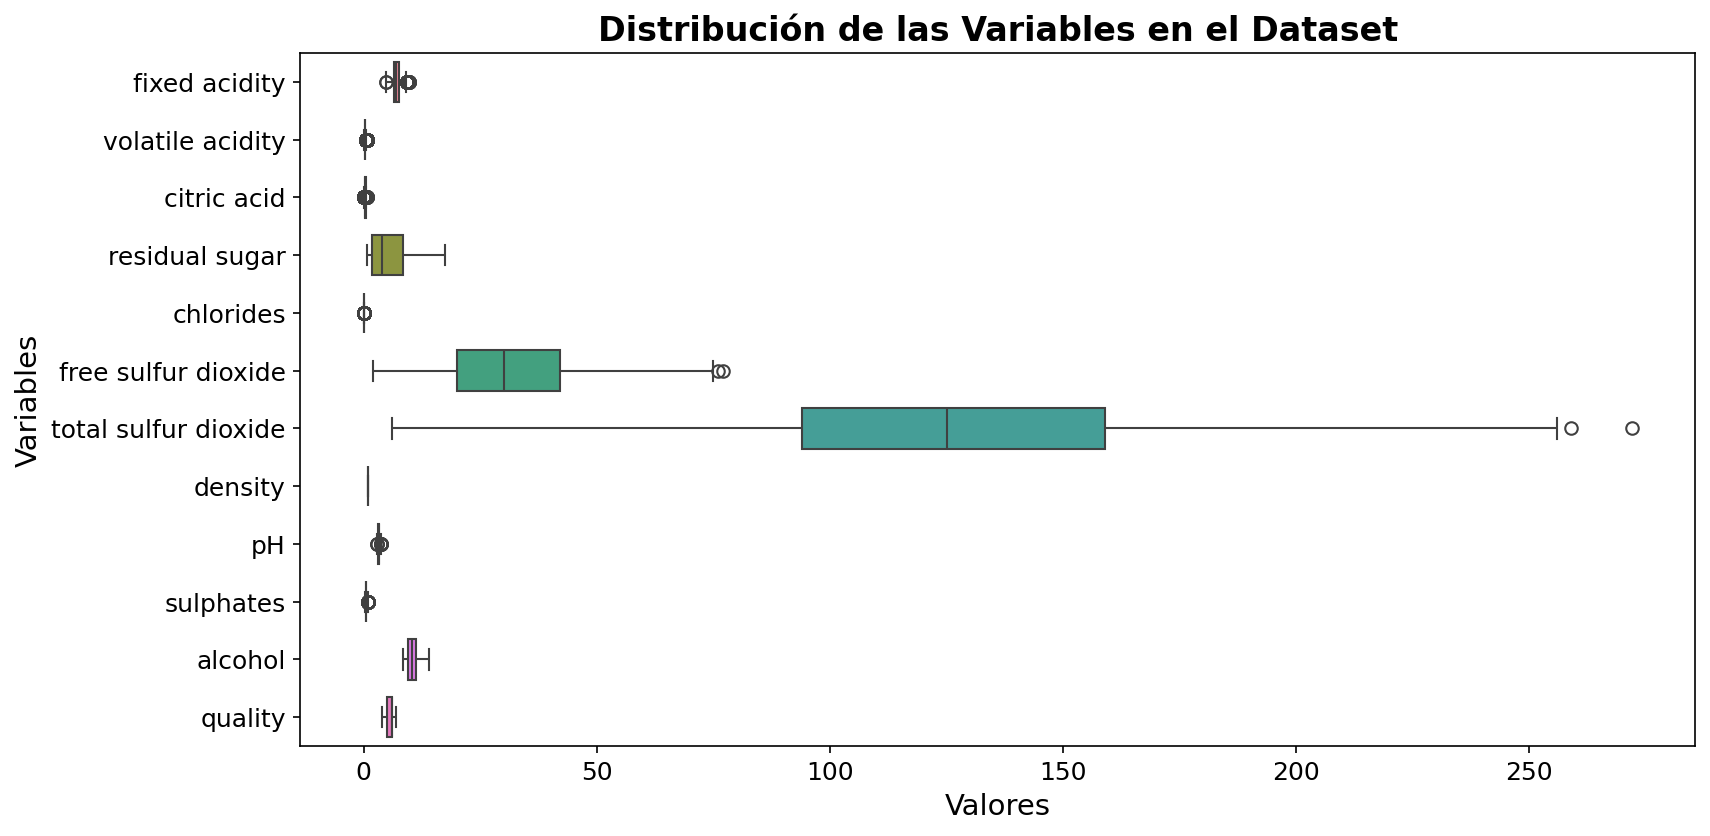

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir tamaño de figura y DPI alto
plt.figure(figsize=(12, 6), dpi=150)

# Crear el boxplot
sns.boxplot(data=df_wine_filtered, orient='h', width=0.7)

# Personalizar estilo y ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Valores", fontsize=14)
plt.ylabel("Variables", fontsize=14)
plt.title("Distribución de las Variables en el Dataset", fontsize=16, fontweight="bold")

# Mostrar la gráfica
plt.show()

### Conclusión sobre el Filtrado de Outliers: 
#### Análisis del Filtrado con IQR

El uso del método IQR (Interquartile Range) para eliminar valores atípicos nos ha llevado a reducir el número total de registros en el dataset de 6497 a 4840, lo que representa una reducción cercana al 25% de los datos.

`Reflexión`:
Dado que el vino es un producto natural sujeto a variaciones en su proceso de fabricación, la presencia de valores extremos no necesariamente indica errores en la medición o registros incorrectos. Estas variaciones pueden ser causadas por múltiples factores en el proceso de fermentación, como:

Diferencias en la composición de la uva (según la región, clima y cosecha).
- Condiciones de fermentación (temperatura, tiempo, tipo de levaduras).
- Interacción de compuestos químicos, como la variabilidad en los sulfitos y la acidez volátil,
- Que dependen del control de oxígeno y la calidad del mosto.
  
El método de Six Sigma (±6σ) es aún más restrictivo que IQR, lo que significa que se eliminarían aún más datos en caso de aplicarlo. Sin embargo, decidimos no eliminar ningún dato con este método, ya que no encontramos indicios claros de errores en la medición.

Por lo tanto, eliminar un cuarto de los datos bajo el criterio del IQR podría falsear la distribución real del dataset y eliminar información valiosa sobre las características del vino.

## Análisis de la variable "quality" respecto a las demás variables
En esta sección, analizaremos cómo la variable objetivo "quality" (calidad del vino) se relaciona con las demás variables del dataset.
El objetivo de esta exploración es identificar patrones y tendencias que puedan ayudarnos a comprender qué características influyen en la calidad del vino.

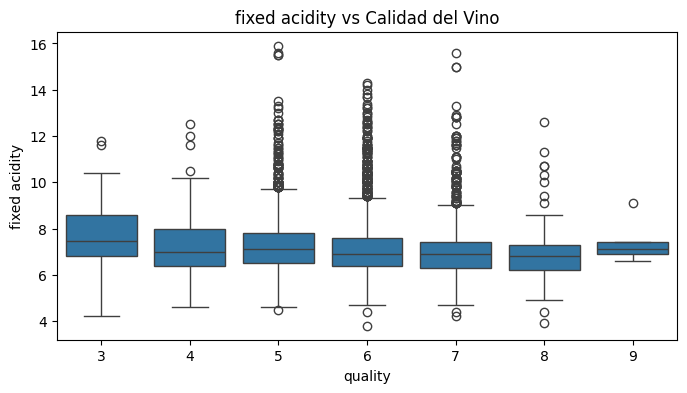

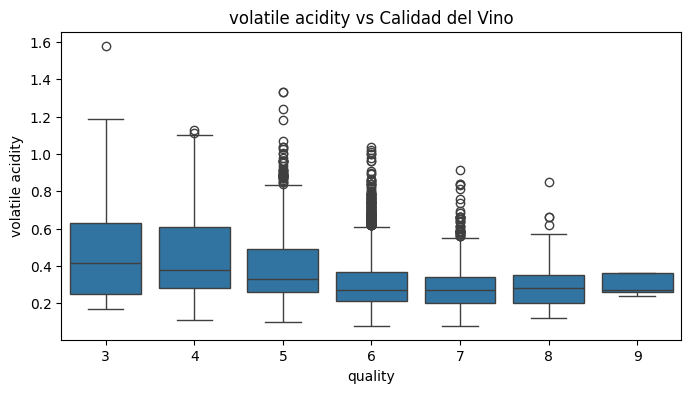

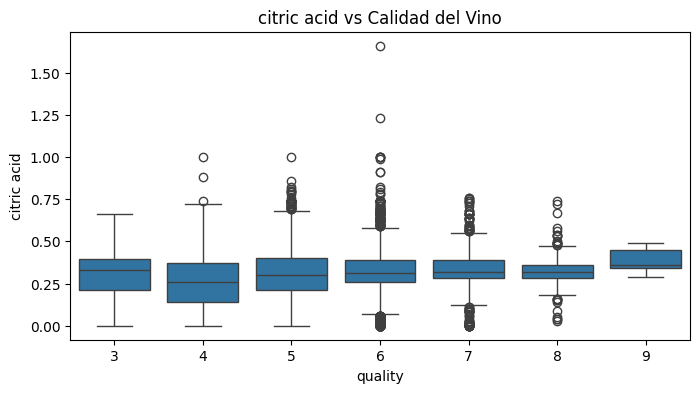

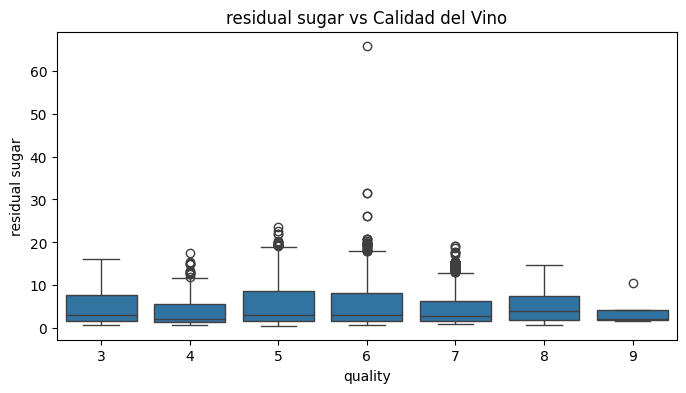

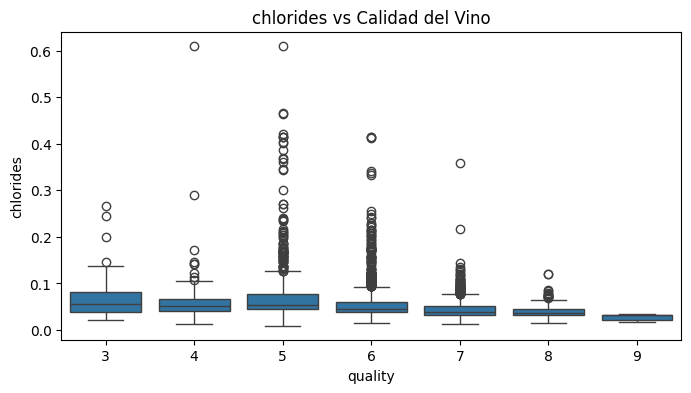

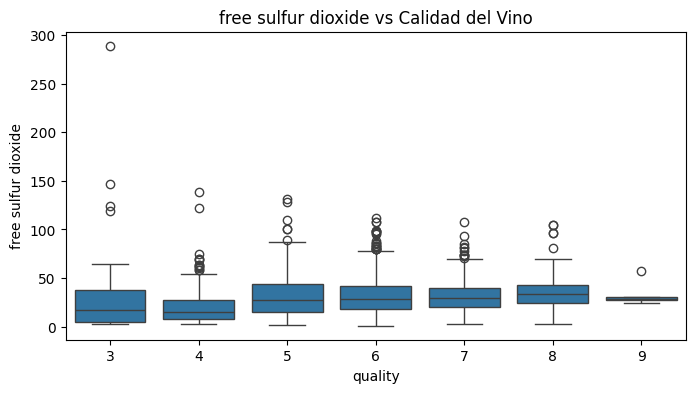

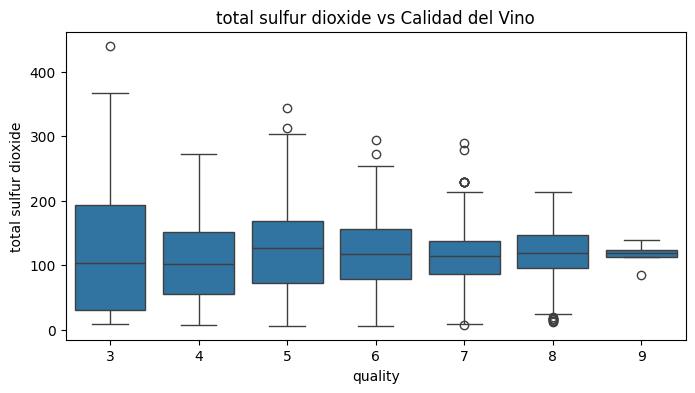

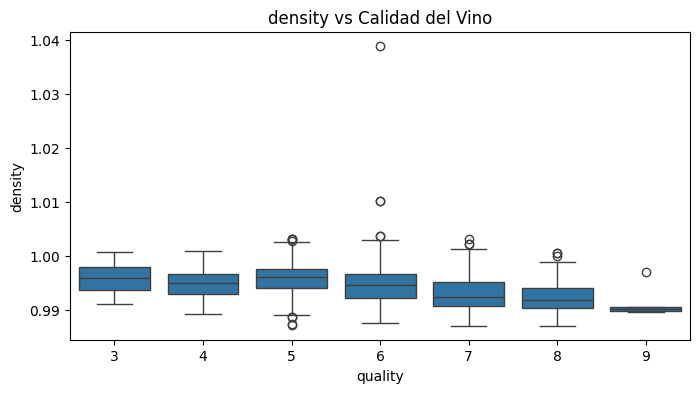

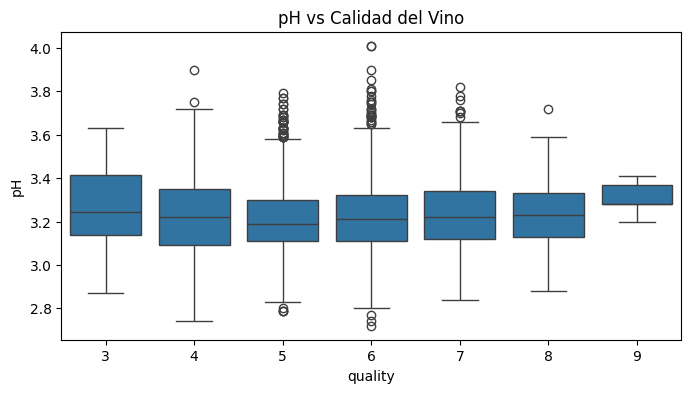

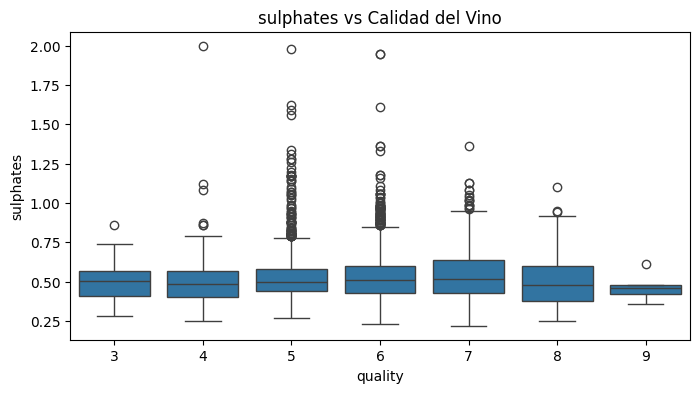

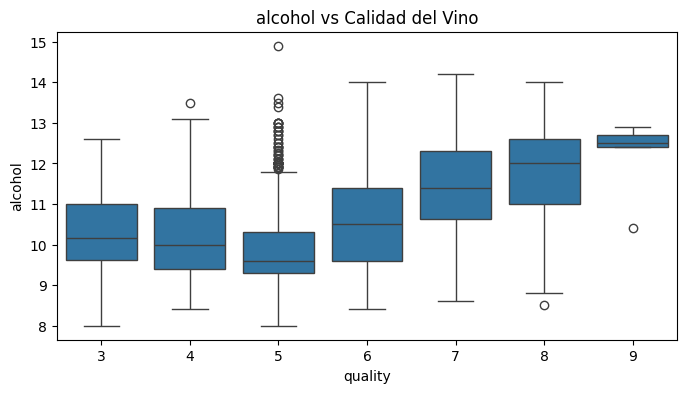

In [23]:
for col in df_wine_quality.select_dtypes(include=['float64']).columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df_wine_quality["quality"], y=df_wine_quality[col])
    plt.title(f'{col} vs Calidad del Vino')
    plt.show()

#### Conclusiones del Análisis de Boxplots
Tras analizar la relación entre la calidad del vino y sus variables fisicoquímicas, se han identificado los siguientes patrones:

**1️. Valores atípicos en todas las calidades**  
- La presencia de valores atípicos en todos los niveles de calidad indica que **no se trata de errores de medición**, sino de variabilidad inherente al proceso de producción del vino.

**2️. Acidez fija y calidad**  
- Se observa una tendencia **decreciente** en la acidez fija a medida que aumenta la calidad del vino.  
- Esto sugiere que vinos más ácidos podrían ser percibidos como de **menor calidad**.

**3️. Acidez volátil y calidad** 
- Los vinos con **mayor acidez volátil** tienden a ser de menor calidad.  
- Un exceso de acidez volátil está relacionado con **defectos sensoriales**, afectando negativamente la percepción del vino.

**4️. Azúcar residual**  
- La mayoría de los vinos presentan niveles **bajos** de azúcar residual, aunque existen valores atípicos extremadamente altos.  
- Esto podría deberse a **fermentaciones incompletas** o, en casos aislados, a errores de medición.  
- Los vinos de mayor calidad tienen un **control más estable del azúcar residual**, mientras que algunos vinos de menor calidad muestran valores desproporcionadamente altos.

**5️. Cloruros**  
- **Altos niveles de cloruros** se asocian con vinos de menor calidad.  
- En vinos de calidad superior, los valores están más concentrados y sin valores extremos.  
- Esto sugiere que un exceso de cloruros **afecta negativamente la percepción de calidad**.

**6️. Dióxido de azufre (libre y total)**  
- **No existe una relación clara** entre altos niveles de dióxido de azufre y la calidad del vino.  
- Sin embargo, los valores atípicos altos están más presentes en vinos de **menor calidad**, lo que sugiere que un exceso de SO₂ podría no estar asociado con vinos de alta gama.

**7️. Sulfatos** 
- **Los valores atípicos en sulfatos son más frecuentes en vinos de menor calidad**, lo que indica que niveles elevados podrían estar relacionados con un menor puntaje de calidad.  
- En vinos de calidad alta, la dispersión de sulfatos es menor, sugiriendo un **mejor equilibrio en su composición química**.

**8️. Alcohol y calidad**
- Los vinos de mejor calidad **tienden a tener un mayor contenido de alcohol**.  
- Además, los valores atípicos altos en alcohol suelen estar en vinos de calidad superior, lo que sugiere que un mayor grado alcohólico podría ser un **indicador de una mejor percepción sensorial**.


In [24]:
#Conclusión
import pandas as pd

# Crear el DataFrame
data = {
    "Variable": [
        "Fixed Acidity", "Volatile Acidity", "Citric Acid", "Residual Sugar", "Chlorides",
        "Free Sulfur Dioxide", "Total Sulfur Dioxide", "Density", "pH", "Sulphates", "Alcohol"
    ],
    "Relación con calidad": [
        "No clara", "Vinos de baja calidad tienen valores altos", "No clara", "Valores altos en vinos de baja calidad",
        "Vinos de baja calidad tienen valores altos", "Valores altos en vinos de baja calidad",
        "Valores altos en vinos de baja calidad", "No clara", "No clara", "Valores altos en vinos de baja calidad",
        "Vinos de alta calidad tienen más alcohol"
    ],
    "¿Eliminar atípicos?": [
        "No", "Sí", "Sí", "Sí", "Sí", "Sí", "Sí", "No", "No", "Sí", "Sí"
    ],
    "Tipo de atípicos a eliminar": [
        "-", "Solo valores atípicos altos", "Solo valores atípicos altos", "Solo valores atípicos altos",
        "Solo valores atípicos altos", "Solo valores atípicos altos", "Solo valores atípicos altos", "-", "-",
        "Solo valores atípicos altos", "Solo valores atípicos bajos"
    ]
}

df = pd.DataFrame(data)
df


,Variable,Relación con calidad,¿Eliminar atípicos?,Tipo de atípicos a eliminar
0,Fixed Acidity,No clara,No,-
1,Volatile Acidity,Vinos de baja calidad tienen valores altos,Sí,Solo valores atípicos altos
2,Citric Acid,No clara,Sí,Solo valores atípicos altos
3,Residual Sugar,Valores altos en vinos de baja calidad,Sí,Solo valores atípicos altos
4,Chlorides,Vinos de baja calidad tienen valores altos,Sí,Solo valores atípicos altos
5,Free Sulfur Dioxide,Valores altos en vinos de baja calidad,Sí,Solo valores atípicos altos
6,Total Sulfur Dioxide,Valores altos en vinos de baja calidad,Sí,Solo valores atípicos altos
7,Density,No clara,No,-
8,pH,No clara,No,-
9,Sulphates,Valores altos en vinos de baja calidad,Sí,Solo valores atípicos altos


Tras analizar los boxplots de cada variable en relación con la calidad del vino, observamos que algunas variables presentan diferencias en la mediana según la calidad, lo que sugiere una posible relación entre ellas. Sin embargo, la visualización de los boxplots no nos permite cuantificar con precisión la fuerza de estas relaciones.

Por ello, utilizamos la correlación de `Pearson` como un primer enfoque para medir la relación lineal entre las variables numéricas y la calidad del vino. Aunque sabemos que Pearson asume normalidad y puede verse afectado por valores atípicos, nos permitirá identificar qué variables pueden tener una relación más fuerte con la calidad del vino.

Tras calcular Pearson, si encontramos variables con baja correlación (< 0.3), consideraremos otros métodos más robustos como `Spearman` o `Kendall`, que no requieren normalidad y son menos sensibles a valores extremos.

In [25]:
import pandas as pd
df_wine_quality_2 = df_wine_quality.copy()

df_wine_quality_2 = df_wine_clean.select_dtypes(include=['float64', 'int64'])

# Calcular la correlación de Pearson
correlation_pearson = df_wine_quality_2.corr(method='pearson')

correlation_pearson


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452,-0.076743
volatile acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640,-0.265699
citric acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493,0.085532
residual sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415,-0.036980
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916,-0.200666
free sulfur dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838,0.055463
total sulfur dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740,-0.041385
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745,-0.305858
pH,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248,0.019506
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1.000000,-0.003029,0.038485


### ¿Por qué representamos la correlación con un mapa de calor?

El uso de un **heatmap** o mapa de calor es una herramienta fundamental para analizar la relación entre variables en nuestro dataset. Nos permite identificar patrones y tendencias de forma visual, facilitando la interpretación de la matriz de correlación de Pearson.

#### Beneficios del uso de un mapa de calor:

- **Visualización intuitiva:** Permite observar de un vistazo qué variables tienen una mayor o menor correlación con la calidad del vino.

- **Identificación rápida de patrones:** Los colores más intensos indican correlaciones más fuertes, ya sean **positivas** o **negativas**, ayudando a detectar relaciones clave entre las variables.

- **Comparación simultánea:** Facilita el análisis de cómo cada variable se relaciona con las demás, detectando posibles **multicolinealidades** (cuando dos o más variables están altamente correlacionadas entre sí).

- **Facilita la selección de variables:** En futuras fases del análisis, este enfoque nos permitirá **identificar las variables más relevantes** para predecir la calidad del vino, ayudando a optimizar el modelo de machine learning.


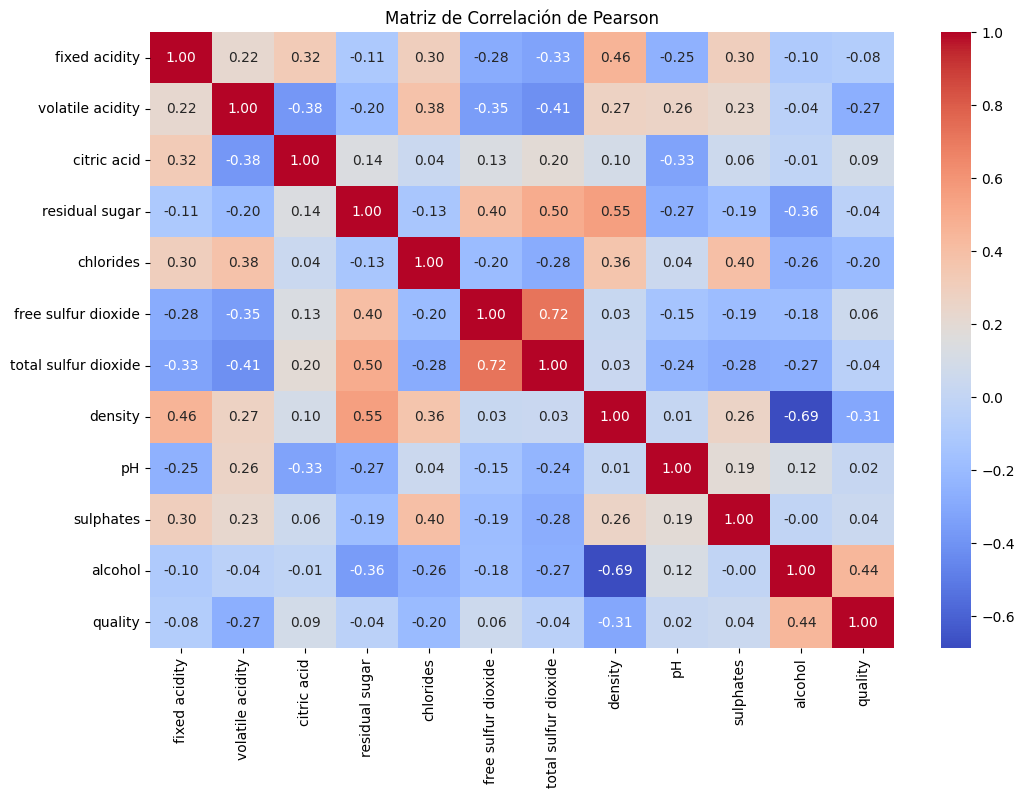

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar el tamaño del gráfico
plt.figure(figsize=(12,8))

# Crear el heatmap
sns.heatmap(correlation_pearson, annot=True, cmap="coolwarm", fmt=".2f")

# Mostrar el gráfico
plt.title("Matriz de Correlación de Pearson")
plt.show()


### Análisis de la correlación de Pearson

Tras analizar los **boxplots** de la variable `quality` en relación con otras variables, procedemos a calcular la **matriz de correlación de Pearson**. Este análisis nos permite identificar **relaciones lineales** entre las características fisicoquímicas del vino y su calidad.

**Hallazgos clave**:
- **Alcohol (`0.44`)**: Es la variable con **mayor correlación positiva** con la calidad del vino, lo que sugiere que vinos con mayor contenido alcohólico tienden a ser mejor valorados.
- **Densidad (`-0.31`)**: Presenta una **correlación negativa moderada**, lo que indica que vinos con mayor densidad suelen tener menor calidad.
- **Volatile Acidity (`-0.27`)**: También muestra una **correlación negativa**, sugiriendo que vinos con mayor acidez volátil tienden a ser de menor calidad.
- **Sulphates (`0.19`)**: Exhibe una **relación positiva débil** con la calidad del vino.
- **Total Sulfur Dioxide (`-0.04`)**: Correlación prácticamente **nula**, indicando que no influye significativamente en la calidad del vino.

**Importante**: La correlación de Pearson solo mide relaciones **lineales** entre variables. Para capturar posibles relaciones **no lineales**, exploraremos la correlación de **Spearman** o **Kendall** en el siguiente paso.


In [27]:
import pandas as pd

# Matriz de correlación de Spearman
spearman_corr = df_wine_quality_2.corr(method='spearman')
print(spearman_corr)

# Matriz de correlación de Kendall
kendall_corr = df_wine_quality_2.corr(method='kendall')
print(kendall_corr)


                      fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000          0.200272     0.270568   
volatile acidity           0.200272          1.000000    -0.295129   
citric acid                0.270568         -0.295129     1.000000   
residual sugar            -0.032254         -0.064384     0.074920   
chlorides                  0.355964          0.415896    -0.074084   
free sulfur dioxide       -0.259914         -0.365673     0.122058   
total sulfur dioxide      -0.233259         -0.343534     0.159355   
density                    0.434056          0.261437     0.065690   
pH                        -0.250044          0.194876    -0.285905   
sulphates                  0.220145          0.255042     0.036898   
alcohol                   -0.110650         -0.023924     0.019653   
quality                   -0.098154         -0.257806     0.105711   

                      residual sugar  chlorides  free sulfur dioxide  \
fixed acidity    

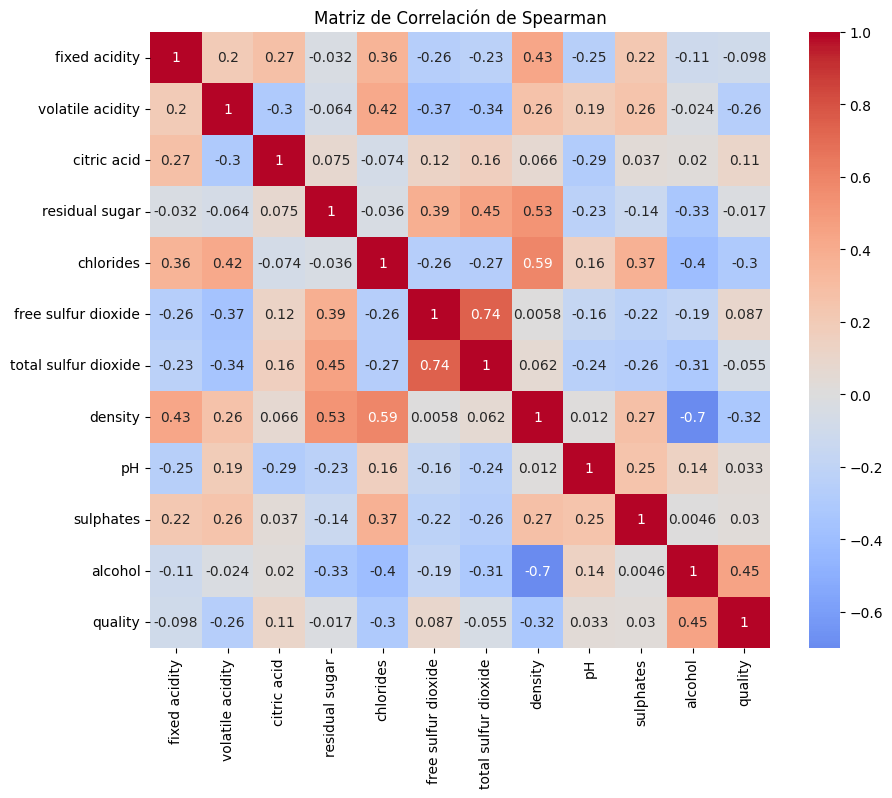

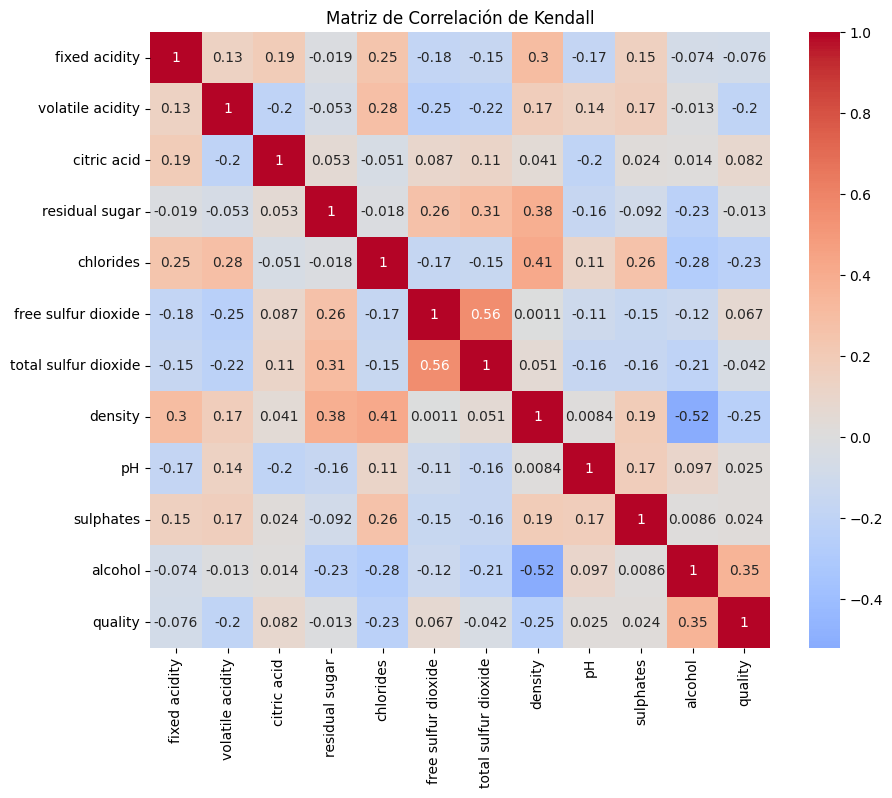

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Para Spearman
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación de Spearman')
plt.show()

# Para Kendall
plt.figure(figsize=(10, 8))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación de Kendall')
plt.show()


#### ¿Qué significa esto?
Dado que ninguna variable individual tiene una relación clara con la calidad del vino, es posible que la calidad dependa de una combinación de múltiples factores en lugar de un solo parámetro químico. Esto sugiere que **técnicas más avanzadas** como modelos de `regresión múltiple` o métodos de `machine learning` podrían ser más útiles para predecir la calidad del vino.

## **Análisis de la Influencia de las Variables en la Calidad del Vino**

Hasta ahora, hemos evaluado la relación entre las variables fisicoquímicas y la calidad del vino mediante boxplots y la correlación de Pearson. Sin embargo, Pearson solo mide relaciones lineales y no nos permite determinar si existen diferencias significativas en la distribución de estas variables entre distintos niveles de calidad del vino.

Para abordar esta limitación, utilizaremos la **prueba de Kruskal-Wallis**, un test no paramétrico que nos permitirá evaluar si existen diferencias estadísticamente significativas en la distribución de cada variable para los distintos niveles de calidad del vino. A diferencia de ANOVA, Kruskal-Wallis no asume normalidad en los datos, lo que lo hace ideal para nuestro caso donde muchas variables no siguen una distribución normal.

### **Objetivo de la Prueba de Kruskal-Wallis**
- Determinar si las diferencias observadas en los boxplots son estadísticamente significativas.
- Evaluar qué variables presentan un impacto más fuerte en la calidad del vino.
- Filtrar aquellas variables con un valor p menor a 0.05, lo que indicaría que la variable tiene un efecto significativo en la calidad.

A continuación, implementamos la prueba de Kruskal-Wallis en nuestras variables numéricas.


In [29]:
import scipy.stats as stats
import pandas as pd

# El DataFrame es df_wine_quality_2 y 'quality' es la variable categórica
variables_numericas = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
                       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 
                       'density', 'pH', 'sulphates', 'alcohol']

# Diccionario para almacenar los resultados de Kruskal-Wallis
kruskal_results = {}

for var in variables_numericas:
    grupos = [df_wine_quality_2[var][df_wine_quality_2['quality'] == q] for q in df_wine_quality_2['quality'].unique()]
    stat, p_value = stats.kruskal(*grupos)
    kruskal_results[var] = {'Estadístico H': stat, 'p-value': p_value}

kruskal_df = pd.DataFrame(kruskal_results).T
kruskal_df


,Estadístico H,p-value
fixed acidity,70.994400,2.556094e-13
volatile acidity,476.765222,8.490051e-100
citric acid,78.383240,7.705582e-15
residual sugar,39.175094,6.613618e-07
chlorides,607.788192,4.872410e-128
free sulfur dioxide,125.878870,9.470318e-25
total sulfur dioxide,53.903642,7.714691e-10
density,758.890647,1.170974e-160
pH,15.273469,1.823312e-02
sulphates,25.078141,3.302641e-04


### **Conclusión del test de Kruskal-Wallis**

El test de **Kruskal-Wallis** se realizó para analizar si existen diferencias significativas en la variable **quality** respecto a las demás variables numéricas del conjunto de datos. 

 **Interpretación de los resultados:**
- **Todas las variables analizadas tienen un impacto estadísticamente significativo en la calidad del vino (`p-value < 0.05`)**, lo que significa que hay diferencias en su distribución entre los distintos niveles de `quality`.
- **Alcohol, densidad, cloruros y acidez volátil tienen los valores de estadístico H más altos**, lo que indica que estas variables muestran las diferencias más marcadas en su distribución según la calidad del vino.

### **Puntos clave**
1. **El alcohol tiene la relación más fuerte con la calidad del vino (`H = 1397.32, p ≈ 0`):** Este resultado es consistente con la matriz de correlación de Pearson, donde el alcohol tenía la correlación más alta con `quality`.
2. **Densidad (`H = 758.89`) y cloruros (`H = 607.78`) también muestran una fuerte variabilidad entre los niveles de calidad.** La densidad puede estar relacionada con el contenido de azúcar residual y el alcohol, mientras que los cloruros pueden estar vinculados a la mineralidad del vino.
3. **El pH tiene un efecto menos pronunciado (`H = 15.27, p = 0.018`), lo que sugiere que, aunque hay una diferencia entre los niveles de calidad, su impacto es menor en comparación con otras variables.**
4. **El azúcar residual (`H = 39.17, p = 6.61e-07`) también muestra diferencias según la calidad, aunque en menor medida que las variables mencionadas anteriormente.**

### **Conclusión final**
 **El alcohol es la variable que más influye en la calidad del vino**, seguido por la **densidad, los cloruros y la acidez volátil**. La presencia de estas diferencias sugiere que estas características juegan un papel clave en la percepción de la calidad del vino y podrían ser utilizadas para modelar su clasificación.


## **Resumen del Proceso Hasta Ahora**

A lo largo del análisis, hemos aplicado diversas técnicas exploratorias y estadísticas para comprender cómo las variables fisicoquímicas influyen en la calidad del vino:

1. **Boxplots**: Visualizamos la distribución de cada variable en función de la calidad del vino, identificando patrones y la presencia de valores atípicos.
2. **Correlaciones (Pearson, Spearman, Kendall)**: Cuantificamos la relación entre la variable `quality` y las demás variables para detectar asociaciones lineales y no lineales.
3. **Prueba de Kruskal-Wallis**: Evaluamos si las distribuciones de las variables presentan diferencias significativas en función de la calidad del vino, sin asumir normalidad en los datos.

### **Resultados Clave**
- **Alcohol, densidad, cloruros y acidez volátil** son las variables que más influyen en la calidad del vino.  
- Los resultados obtenidos son consistentes a lo largo de las distintas metodologías utilizadas, reforzando la validez de nuestros hallazgos.  
- Al comprender estas relaciones, podremos seleccionar mejor las variables más relevantes para futuros modelos predictivos.  


Dado que estamos analizando un **dataset de vinos**, en el que las variables representan mediciones químicas, es importante considerar que los valores atípicos no necesariamente indican **errores de medición**, sino que pueden formar parte de la **variabilidad natural del proceso de fabricación del vino**.

**¿Por qué no asumimos errores de medida?**

En la producción de vino, la fermentación y otros procesos químicos pueden generar variaciones naturales en las mediciones.  
Muchos de los valores atípicos se encuentran en rangos de vinos de **calidad más baja**, lo que sugiere que podrían reflejar diferencias reales en la composición química de los vinos.  
Rechazar demasiados valores extremos podría **distorsionar el análisis** y llevarnos a conclusiones erróneas sobre la relación entre las variables y la calidad del vino.  

Dado que estos valores pueden afectar ciertos análisis y modelos predictivos, evaluaremos distintas estrategias para su manejo, asegurándonos de **minimizar el impacto sin perder información relevante**.  

### Aplicación de Winsorización para el tratamiento de valores atípicos

Dado que eliminar valores atípicos puede llevar a una pérdida significativa de información y distorsionar el análisis, optamos por una técnica más conservadora: **Winsorización**. 

La **Winsorización** es un método de tratamiento de outliers en el que en lugar de eliminar los valores extremos, estos se reemplazan por un percentil definido, reduciendo así su impacto sin afectar drásticamente la distribución de los datos.

#### ¿Por qué usamos Winsorización en lugar de eliminar outliers?
- **Preserva la cantidad total de datos**: No eliminamos observaciones, lo que evita sesgar el conjunto de datos.  
- **Menos impacto en la variabilidad natural**: Considerando que los valores extremos pueden reflejar procesos naturales en la producción del vino, esta técnica es más adecuada.  
- **Reduce el efecto de valores extremos en modelos predictivos**: Evita que los outliers dominen la relación entre variables sin necesidad de eliminarlos por completo.

Aplicaremos Winsorización con un umbral del **0.5% en ambos extremos**, lo que significa que los valores más bajos y más altos se reemplazarán por los valores del percentil 0.5 y 99.5 respectivamente.


In [30]:
from scipy.stats.mstats import winsorize
import numpy as np

def aplicar_winsorizacion(df, limits=[0.005, 0.005]):

    df_winsorized = df.copy()  # Copiar para evitar modificar el original
    
    # Aplicar winsorización a cada columna numérica
    for col in df_winsorized.select_dtypes(include=['float64', 'int64']).columns:
        if col != "quality":  # Excluir la columna 'quality' si es la variable objetivo
            df_winsorized[col] = np.asarray(winsorize(df_winsorized[col].values, limits=limits))

    return df_winsorized

# Aplicar winsorización al DataFrame
df_wine_quality_winsorized = aplicar_winsorizacion(df_wine_quality_2)

# Reincorporamos la columna 'type' al DataFrame winsorizado
df_wine_quality_winsorized["type-wine"] = df_wine_quality["type-wine"]



In [31]:
df_wine_quality_winsorized.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type-wine
82,7.1,0.34,0.20,6.1,0.063,47.0,164.0,0.99460,3.17,0.42,10.0,5,white
1032,8.1,0.82,0.00,4.1,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5,red
1173,7.6,0.36,0.31,1.7,0.079,26.0,65.0,0.99716,3.46,0.62,9.5,6,red
2303,6.9,0.44,0.18,11.8,0.051,26.0,126.0,0.99750,3.23,0.48,9.1,5,white
272,5.8,0.25,0.26,13.1,0.051,44.0,148.0,0.99720,3.29,0.38,9.3,5,white
3561,7.0,0.48,0.12,4.5,0.050,23.0,86.0,0.99398,2.86,0.35,9.0,5,white
2616,6.5,0.18,0.41,14.2,0.039,47.0,129.0,0.99678,3.28,0.72,10.3,7,white
3952,7.0,0.16,0.30,2.6,0.043,34.0,90.0,0.99047,2.88,0.47,11.2,6,white
1503,6.8,0.36,0.24,4.6,0.039,24.0,124.0,0.99090,3.27,0.34,12.6,7,white
1345,7.3,0.39,0.37,1.1,0.043,36.0,113.0,0.99100,3.39,0.48,12.7,8,white


In [32]:
import pandas as pd

# Comparar antes y después de winsorización
stats_before = df_wine_quality_2.describe().T  # Estadísticas antes
stats_after = df_wine_quality_winsorized.describe().T  # Estadísticas después

# Unir ambas tablas para comparar mínimo y máximo
stats_comparison = pd.concat(
    [stats_before["min"], stats_before["max"], stats_after["min"], stats_after["max"]], axis=1
)
stats_comparison.columns = ["Min Antes", "Max Antes", "Min Después", "Max Después"]

display(stats_comparison)


,Min Antes,Max Antes,Min Después,Max Después
fixed acidity,3.80000,15.90000,4.90000,12.7000
volatile acidity,0.08000,1.58000,0.11500,0.9650
citric acid,0.00000,1.66000,0.00000,0.7400
residual sugar,0.60000,65.80000,0.80000,19.4000
chlorides,0.00900,0.61100,0.01800,0.2430
free sulfur dioxide,1.00000,289.00000,3.00000,86.0000
total sulfur dioxide,6.00000,440.00000,9.00000,247.0000
density,0.98711,1.03898,0.98862,1.0014
pH,2.72000,4.01000,2.86000,3.7000
sulphates,0.22000,2.00000,0.28000,1.1300


## Conclusiones de la Winsorización

### Reducción de valores extremos  
- La winsorización ha reducido los valores más extremos de las variables.  
- **Ejemplo:** `residual sugar` tenía un máximo de **65.8** y ahora está en **19.4**, mientras que `total sulfur dioxide` bajó de **440** a **247**.  
- También se han ajustado los valores mínimos, aunque en menor medida.  

### Menor impacto en algunas variables  
- En variables como `pH`, `density` y `citric acid`, el efecto es mínimo debido a la ausencia de valores extremos muy marcados.  
- Esto indica que la winsorización ha tenido mayor impacto en variables con mayor dispersión y presencia de outliers.  

### Ajuste más controlado  
- A diferencia de eliminar outliers, la winsorización **mantiene todos los datos dentro de un rango razonable** sin eliminar filas del dataset.  
- Así, evitamos la pérdida de información valiosa y prevenimos distorsiones excesivas en la distribución.  

### Mejor comportamiento en modelos predictivos  
- Con una distribución más estable, el dataset será más interpretable y favorecerá el rendimiento de modelos de machine learning.  
- Variables como `volatile acidity` y `free sulfur dioxide` ya no tendrán valores extremos que podrían influir desproporcionadamente en el análisis.  


# 4. Almacenar los datos los datos limpios en SQLite

Después de procesar y limpiar los datos, almacenaremos el **DataFrame final** en una base de datos para facilitar su gestión y futuras consultas.  
Para este propósito, utilizaremos el dataset **`df_wine_quality_winsorized`**, que contiene los datos tras el tratamiento de valores atípicos mediante winsorización.  

---

## ¿Qué es SQLite y por qué lo usamos?

**SQLite** es un sistema de gestión de bases de datos ligero y sin servidor, ideal para proyectos de análisis de datos porque:  

- **Es fácil de usar:** No requiere configuración de un servidor, lo que facilita su implementación en notebooks y proyectos locales.  
- **Es eficiente y rápido:** Permite realizar consultas SQL sin necesidad de conectarse a una base de datos externa.  
- **Facilita la organización de datos:** Nos permite almacenar los datos limpios y acceder a ellos posteriormente sin necesidad de procesar el dataset desde cero.  
- **Compatible con Python:** La librería `sqlite3` nos permite interactuar con la base de datos directamente desde nuestro código.  

Al almacenar nuestros datos en SQLite, garantizamos una mejor **persistencia**, **estructura** y **accesibilidad** para futuras fases del análisis y modelado.

PAra cualquier consulta sigue la documentación oficial de SQLite: [SQLite Python Documentation](https://docs.python.org/3/library/sqlite3.html).

Para comenzar, necesitas conectar tu script de Python a una base de datos SQLite. Puedes hacerlo con:

In [33]:
import sqlite3

# Conectamos a una base de datos y se crea automáticamente ya que no existe
con = sqlite3.connect(r"C:\Users\Oscar\Documents\MBIT_Oscar\MBIT_202501_Proyecto_Consolidacion_1\data\bbdd_wine_quality.db")

# Creamos un cursor para ejecutar comandos SQL
cur = con.cursor()

In [34]:
# Ejecutamos una consulta simple para verificar la conexión
try:
    cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tablas = cur.fetchall()
    print("Conexión exitosa. Tablas en la base de datos:", tablas)
except sqlite3.Error as e:
    print("Error en la conexión:", e)

Conexión exitosa. Tablas en la base de datos: [('wine_quality_clean',)]


Ahora que hemos configurado una conexión y un cursor, podemos crear una tabla con nuestros datos bien filtrados

In [35]:
import pandas as pd

# Insertamos el DataFrame en la base de datos SQLite
df_wine_quality_winsorized.to_sql("wine_quality_clean", con, if_exists="replace", index=False)

# Confirmamos que la tabla se creó correctamente
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print("Tablas en la base de datos:", cur.fetchall())


Tablas en la base de datos: [('wine_quality_clean',)]


# 5. Realizaremos las siguientes consultas en SQLite

##### 5.1 Consulta 1: ¿Cuál es el promedio de calidad (`quality`) por tipo de vino (`type`)?

In [36]:
# Ejecutar la consulta SQL para obtener el promedio de calidad por tipo de vino
query = """
SELECT "type-wine", AVG(quality) AS avg_quality
FROM wine_quality_clean
GROUP BY "type-wine";
"""

# Ejecutamos la consulta
cur.execute(query)

# Obtenemos los resultados
resultados = cur.fetchall()

# Mostramos los resultados
for row in resultados:
    print(f"Tipo de vino: {row[0]}, Calidad promedio: {row[1]:.2f}")


Tipo de vino: red, Calidad promedio: 5.64
Tipo de vino: white, Calidad promedio: 5.88


##### 5.2 Consulta 2: ¿Cuántos vinos tienen un nivel de alcohol superior a 10.5, agrupados por tipo?

In [37]:
# ¿Cuántos vinos tienen un nivel de alcohol superior a 10.5, agrupados por tipo?
query = """
SELECT "type-wine", COUNT(*) AS count_vinos
FROM wine_quality_clean
WHERE alcohol > 10.5
GROUP BY "type-wine";
"""

cur.execute(query)
resultados = cur.fetchall()

# Mostrar resultados de forma legible
for row in resultados:
    print(f"Tipo de vino: {row[0]}, Cantidad de vinos con alcohol > 10.5: {row[1]}")


Tipo de vino: red, Cantidad de vinos con alcohol > 10.5: 616
Tipo de vino: white, Cantidad de vinos con alcohol > 10.5: 2163


##### 5.3 Consulta 3: Obtén el conteo de vinos por nivel de acidez (`fixed acidity`) agrupados en rangos (por ejemplo, de 0-5, 5-10, 10-15).

In [38]:
# 3. Consulta 3: Obtén el conteo de vinos por nivel de acidez (`fixed acidity`) agrupados en rangos (por ejemplo, de 0-5, 5-10, 10-15).
query = """
SELECT 
    CASE 
        WHEN "fixed acidity" >= 0 AND "fixed acidity" < 5 THEN '0-5'
        WHEN "fixed acidity" >= 5 AND "fixed acidity" < 10 THEN '5-10'
        WHEN "fixed acidity" >= 10 AND "fixed acidity" < 15 THEN '10-15'
        ELSE '15+' 
    END AS acidity_range,
    COUNT(*) AS count_vinos
FROM wine_quality_clean
GROUP BY acidity_range
ORDER BY acidity_range;

"""

cur.execute(query)
resultados = cur.fetchall()

# Mostrar resultados de forma legible
for row in resultados:
    print(f"Rango de acidez: {row[0]}, Cantidad de vinos: {row[1]}")


Rango de acidez: 0-5, Cantidad de vinos: 33
Rango de acidez: 10-15, Cantidad de vinos: 286
Rango de acidez: 5-10, Cantidad de vinos: 6178


# 6. Exportación de los datos a JSONLines
De cara a una potencial insercion en una base de datos noSQL como `mongoDB`, podemos servirnos de pandas para preparar los datos.

##### ¿Qué estructura de datos de python es la más similar a un documento noSQL?

MongoDB almacena datos en formato BSON (una versión binaria de JSON), donde cada documento es una estructura clave-valor, igual que los diccionarios en Python.

##### Usa Pandas para transformar los datos de una de las consultas en un archivo JSONLines.

In [39]:
# Primero haremos una copia del df limpio
df_copy_wine_quality_winsorized = df_wine_quality_winsorized.copy()
#df_wine_quality_winsorized.head()
df_copy_wine_quality_winsorized.to_json(
    path_or_buf = r"C:\Users\Oscar\Documents\MBIT_Oscar\MBIT_202501_Proyecto_Consolidacion_1\data\mongodb_wine_quality.jsonl",
    orient = "records",
    lines = True,
    index = False
)

##### Usa la librería `jsonlines` para guardar el archivo.

In [40]:
!pip install jsonlines

In [41]:
import jsonlines

with jsonlines.open("../data/wine_quality_jsonlines.jsonl", mode="w") as writer:
    writer.write_all(df_copy_wine_quality_winsorized.to_dict(orient="records"))

##### ¿Qué problemas podrían surgir al transformar un dataframe en jsonlines?

 Tipos de datos incompatibles:

- `np.array`: Se convierte en listas, pero algunas bases NoSQL no lo soportan bien.
- `pd.datetime`: Puede que se transforme en string en un formato inesperado.
- `NaN en pandas`: En JSON se convierte en null, lo que puede causar problemas en bases de datos.

##### Añade una columna que sea originalmente un `np.array`,¿qué sucede al transformarlo en jsonlines?

In [42]:
import numpy as np

# Agregar una columna con un np.array simple
df_copy_wine_quality_winsorized["array_column"] = np.array([np.array([1, 2, 3])] * len(df_copy_wine_quality_winsorized))

# Exportar a JSONLines
df_copy_wine_quality_winsorized.to_json(
    "../data/wine_quality_with_array.jsonl", 
    orient="records", 
    lines=True
)


ValueError: Expected a 1D array, got an array with shape (6497, 3)

##### ¿Qué sucede aquí?

Durante el proceso de manipulación de datos, nos encontramos con un **error** al intentar agregar una columna con un array multidimensional.

##### Causa del problema:
- Intentamos agregar una columna que contiene un `np.array` con **forma (6497, 3)**.
- **Error esperado**: *Pandas no admite arrays de múltiples dimensiones en una sola columna* porque espera valores escalares o listas.
- Esto genera conflictos al intentar **exportar el DataFrame a formato JSONLines**, ya que `pandas.to_json()` no sabe cómo manejar esta estructura.

##### Posible solución:
Para evitar este problema, podemos **convertir el array en múltiples columnas separadas** o transformarlo en una lista con valores serializables antes de incorporarlo al DataFrame.

---
Ahora exploraremos opciones para resolver este inconveniente y garantizar la correcta exportación de los datos.


In [43]:
df_copy_wine_quality_winsorized["array_column"] = [np.array([1, 2, 3]).tolist()] * len(df_copy_wine_quality_winsorized)

# Exportar a JSONLines
df_copy_wine_quality_winsorized.to_json(
    "../data/wine_quality_with_array.jsonl", 
    orient="records", 
    lines=True
)

##### ¿Qué estamos haciendo aquí para corregirlo?

Hemos encontrado un problema al intentar almacenar un `np.array` multidimensional en un **DataFrame de pandas**. Para solucionarlo, aplicamos una conversión que permite su correcta manipulación y exportación.

##### Solución aplicada:
1️. **Convertimos el `np.array` a una lista de Python** usando `.tolist()`.  
   - En lugar de asignar un array directamente, ahora cada celda de la columna `"array_column"` contiene una **lista** con valores del tipo `[1, 2, 3]`, lo que sí es aceptado por `pandas` y formatos de exportación como JSONLines.

2️. **Verificamos compatibilidad con `pandas.to_json()`**  
   - Ahora, al usar `pandas.to_json(..., lines=True)`, **no hay errores**, y el archivo se genera correctamente.

---

##### Conclusión Final

**Limitación de `pandas`**  
- `np.array` **no puede asignarse directamente** a un DataFrame si es multidimensional.  
- `pandas` solo admite valores escalares o listas dentro de una celda.

**Conversión a lista**  
- **Al aplicar `.tolist()`, el problema desaparece**, permitiendo que `pandas` y JSONLines manejen correctamente los datos.  
- Algunas **bases de datos NoSQL** pueden aceptar listas directamente, pero otras pueden requerir que se guarden como **strings**.

**Consideraciones antes de exportar datos**  
- **Asegurar compatibilidad** con el formato de destino antes de exportar.  
- Revisar si la estructura de datos es soportada por JSON, SQL o bases NoSQL.  

**Lección clave:**  
Antes de exportar datos a **JSONLines** o bases de datos **NoSQL**, es fundamental **verificar la compatibilidad** de los tipos de datos con el formato final para evitar errores en la manipulación y análisis de la información.


##### Añade una columna que sea originalmente un `pd.datetime`,¿qué sucede al transformarlo en jsonlines?

In [44]:
import pandas as pd

df_copy_wine_quality_winsorized["date_column"] = pd.to_datetime("2024-01-01")

df_copy_wine_quality_winsorized.to_json(
    "../data/wine_quality_with_date.jsonl", 
    orient="records", 
    lines=True
)

In [45]:
with open("../data/wine_quality_with_date.jsonl", "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        print(line.strip())  # Muestra la línea completa en formato JSON
        if i == 2:  # Solo mostramos las primeras 2 líneas
            break

{"fixed acidity":7.4,"volatile acidity":0.7,"citric acid":0.0,"residual sugar":1.9,"chlorides":0.076,"free sulfur dioxide":11.0,"total sulfur dioxide":34.0,"density":0.9978,"pH":3.51,"sulphates":0.56,"alcohol":9.4,"quality":5,"type-wine":"red","array_column":[1,2,3],"date_column":1704067200000}
{"fixed acidity":7.8,"volatile acidity":0.88,"citric acid":0.0,"residual sugar":2.6,"chlorides":0.098,"free sulfur dioxide":25.0,"total sulfur dioxide":67.0,"density":0.9968,"pH":3.2,"sulphates":0.68,"alcohol":9.8,"quality":5,"type-wine":"red","array_column":[1,2,3],"date_column":1704067200000}
{"fixed acidity":7.8,"volatile acidity":0.76,"citric acid":0.04,"residual sugar":2.3,"chlorides":0.092,"free sulfur dioxide":15.0,"total sulfur dioxide":54.0,"density":0.997,"pH":3.26,"sulphates":0.65,"alcohol":9.8,"quality":5,"type-wine":"red","array_column":[1,2,3],"date_column":1704067200000}


##### Conversión de `pd.datetime` en JSONLines

Al exportar el **DataFrame** a **JSONLines**, hemos observado que la columna `"date_column"` no mantiene su formato original y en su lugar aparece como un número entero grande.

##### ¿Por qué sucede esto?

**Serialización de `pd.datetime` en JSONLines**
- `pandas`, al exportar columnas de tipo `datetime`, **convierte automáticamente** los valores a **timestamps UNIX** en milisegundos.
- JSONLines **no tiene un tipo de dato nativo para fechas**, por lo que almacena estos valores como **números enteros** representando el número de milisegundos desde **1970-01-01 (Epoch Time)**.

In [46]:
df_copy_wine_quality_winsorized["date_column"] = pd.to_datetime("2024-01-01")

df_copy_wine_quality_winsorized["date_column"] = df_copy_wine_quality_winsorized["date_column"].astype(str)

df_copy_wine_quality_winsorized.to_json(
    "../data/wine_quality_with_date.jsonl", 
    orient="records", 
    lines=True
)

with open("../data/wine_quality_with_date.jsonl", "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        print(line.strip())  # Muestra la línea completa en formato JSON
        if i == 2:  # Solo mostramos las primeras 5 líneas
            break


{"fixed acidity":7.4,"volatile acidity":0.7,"citric acid":0.0,"residual sugar":1.9,"chlorides":0.076,"free sulfur dioxide":11.0,"total sulfur dioxide":34.0,"density":0.9978,"pH":3.51,"sulphates":0.56,"alcohol":9.4,"quality":5,"type-wine":"red","array_column":[1,2,3],"date_column":"2024-01-01"}
{"fixed acidity":7.8,"volatile acidity":0.88,"citric acid":0.0,"residual sugar":2.6,"chlorides":0.098,"free sulfur dioxide":25.0,"total sulfur dioxide":67.0,"density":0.9968,"pH":3.2,"sulphates":0.68,"alcohol":9.8,"quality":5,"type-wine":"red","array_column":[1,2,3],"date_column":"2024-01-01"}
{"fixed acidity":7.8,"volatile acidity":0.76,"citric acid":0.04,"residual sugar":2.3,"chlorides":0.092,"free sulfur dioxide":15.0,"total sulfur dioxide":54.0,"density":0.997,"pH":3.26,"sulphates":0.65,"alcohol":9.8,"quality":5,"type-wine":"red","array_column":[1,2,3],"date_column":"2024-01-01"}


Utilizando es astype(str) En lugar de guardar la fecha como 1704067200000 (milisegundos desde Epoch), ahora se almacena en formato ISO 8601 ("2024-01-01 00:00:00"), haciéndolo más legible y compatible con bases de datos NoSQL como MongoDB.

# 7. Análisis de la calidad del vino

##### 7.1 Inspecciona qué caracteriza a los vinos tintos y blancos con mayor calidad (`quality`).

##### 7.2 Usa análisis estadístico, gráficos o cualquier técnica que consideres relevante para identificar patrones.

### Objetivo del Análisis de la Calidad del Vino

En esta sección, nuestro objetivo es identificar patrones en los datos que nos ayuden a comprender qué factores influyen en la calidad del vino. Para ello, utilizaremos visualizaciones y modelos estadísticos para evaluar las relaciones entre las características químicas y la variable `quality`.

El análisis se enfocará en dos aspectos principales:

1️. **Identificación de Patrones**:  
   - Utilizaremos gráficos para visualizar cómo las diferentes variables se relacionan con la calidad del vino.  
   - Analizaremos tendencias y posibles agrupaciones dentro de los datos.

2️. **Modelización Predictiva**:  
   - Aplicaremos técnicas de aprendizaje automático para intentar predecir la calidad del vino en función de sus características.  
   - Compararemos diferentes modelos para evaluar cuál ofrece un mejor desempeño en la predicción de `quality` utilizando el dataset original.

Este enfoque nos permitirá no solo entender qué factores están asociados con la calidad del vino, sino también desarrollar herramientas para predecir su clasificación con base en sus propiedades químicas.


# Elección de Modelos para Identificar Patrones en la Calidad del Vino

Para responder al ejercicio y determinar qué características definen a los vinos de mayor calidad, debemos identificar patrones en los datos. Esto implica segmentar los vinos en grupos y analizar relaciones entre variables. Aquí es donde los modelos de **clustering** y **análisis de correlación** resultan útiles.

## ¿Qué modelo utilizar?

Para este caso, **clustering** es la mejor opción, ya que nos permite descubrir grupos ocultos en los datos sin necesidad de etiquetas previas. Esto nos ayudará a **identificar qué características diferencian los vinos de mejor calidad**.

---

## Paso 1: Análisis Exploratorio Inicial (EDA)  

Antes de aplicar clustering, es fundamental realizar un **análisis exploratorio de datos (EDA)** para comprender la distribución de `quality` y su relación con otras variables.

### 1. Inspeccionar la Distribución de `quality`

- **Objetivo:** Analizar cuántos vinos hay en cada nivel de calidad.  
- **Cómo hacerlo:** Utilizar un gráfico de barras o `value_counts()` para visualizar la frecuencia de cada categoría de calidad.

### ¿Qué buscamos?  

- Evaluar si la calidad está **bien distribuida** o si hay una concentración excesiva en ciertos valores (por ejemplo, si la mayoría de los vinos tienen calidad **5-6**).  
- Detectar **clases raras**, como muy pocos vinos con calidad **9**, lo que podría influir en los resultados del clustering.  

---

A continuación, procederemos con la inspección gráfica y estadística de la variable `quality` antes de aplicar técnicas de clustering.


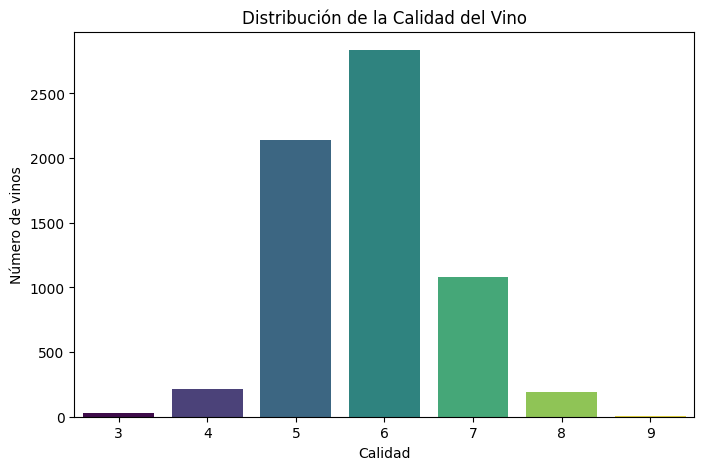

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Conteo de vinos por calidad
plt.figure(figsize=(8,5))
sns.countplot(x=df_wine_quality_winsorized['quality'], hue=df_wine_quality_winsorized['quality'], palette='viridis', legend=False)
plt.title("Distribución de la Calidad del Vino")
plt.xlabel("Calidad")
plt.ylabel("Número de vinos")
plt.show()

# Ver valores únicos y su conteo
df_wine_quality_winsorized["quality"].value_counts()


**2️. Revisar Correlaciones con quality**
- Objetivo: Identificar qué variables podrían influir más en la calidad.
- Cómo hacerlo: Matriz de correlación con quality.
**¿Qué buscamos?**

Variables con alta correlación positiva o negativa con quality.
Por ejemplo, si alcohol tiene una correlación fuerte con quality, podría ser un factor clave en vinos de alta calidad.

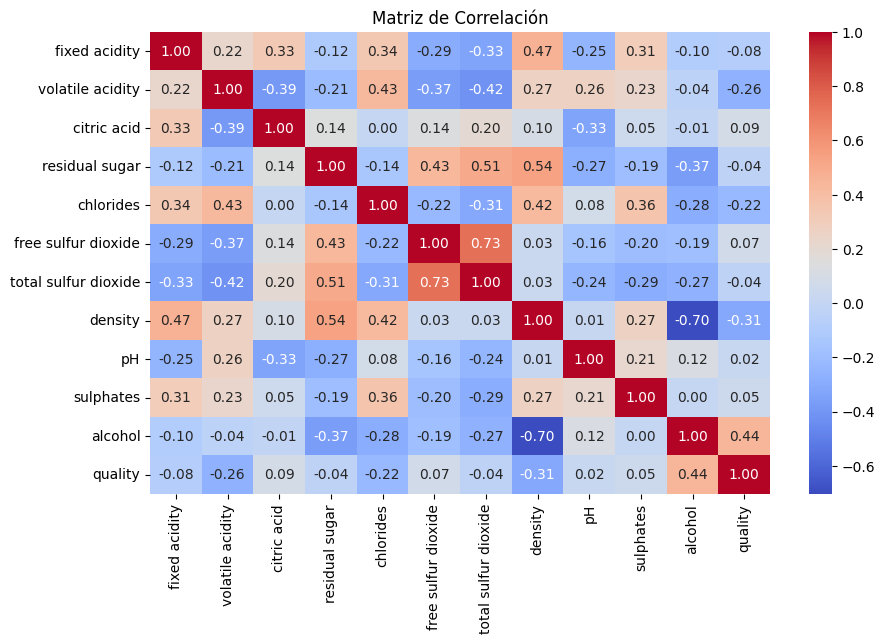

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Filtrar solo las columnas numéricas antes de calcular la correlación
numeric_cols = df_wine_quality_winsorized.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f")

plt.title("Matriz de Correlación")
plt.show()


**3. Revisar Distribución de Variables Clave**
- Objetivo: Ver cómo están distribuidas variables importantes como alcohol, density, volatile acidity, chlorides.
- Cómo hacerlo: Histogramas y Boxplots.

**¿Qué buscamos?**

Si hay diferencias en las distribuciones entre vinos de distinta calidad.
Si hay valores extremos en alguna variable.
Si alguna variable sigue una distribución normal o está sesgada.

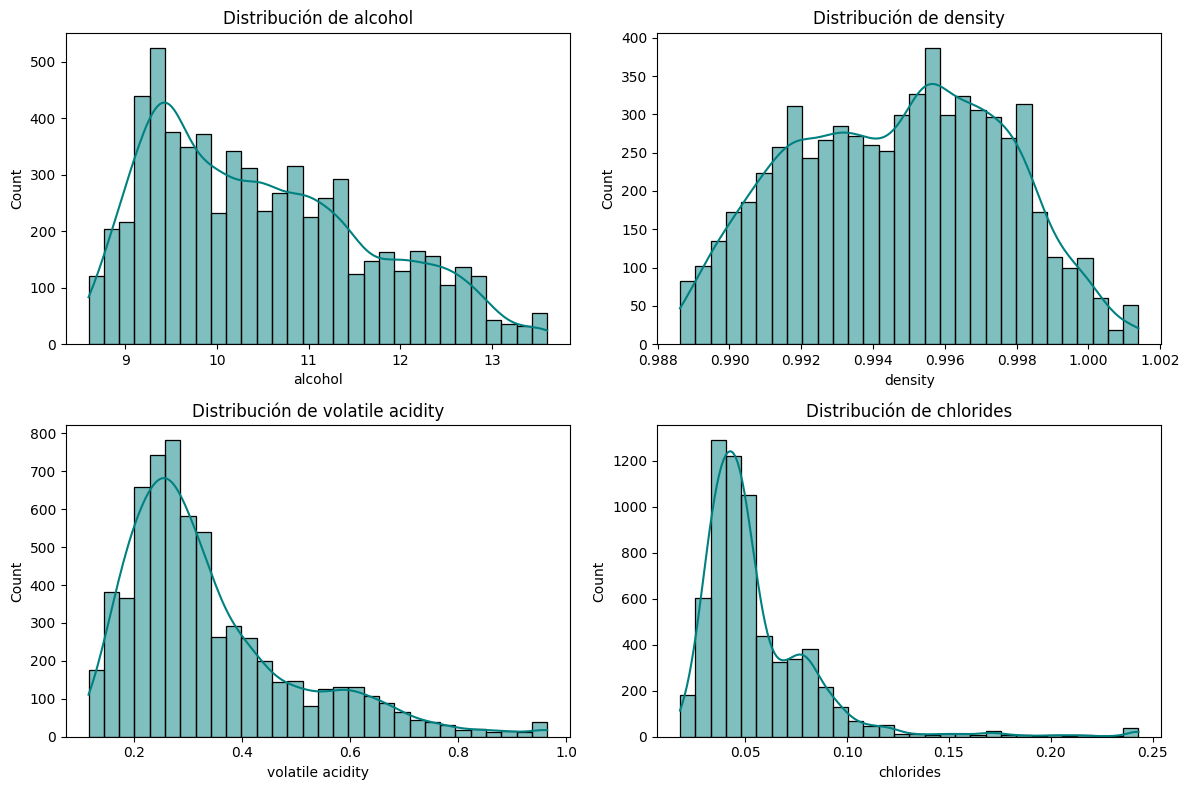

In [49]:
features = ["alcohol", "density", "volatile acidity", "chlorides"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_wine_quality_winsorized[col], kde=True, bins=30, color="teal")
    plt.title(f"Distribución de {col}")
plt.tight_layout()
plt.show()

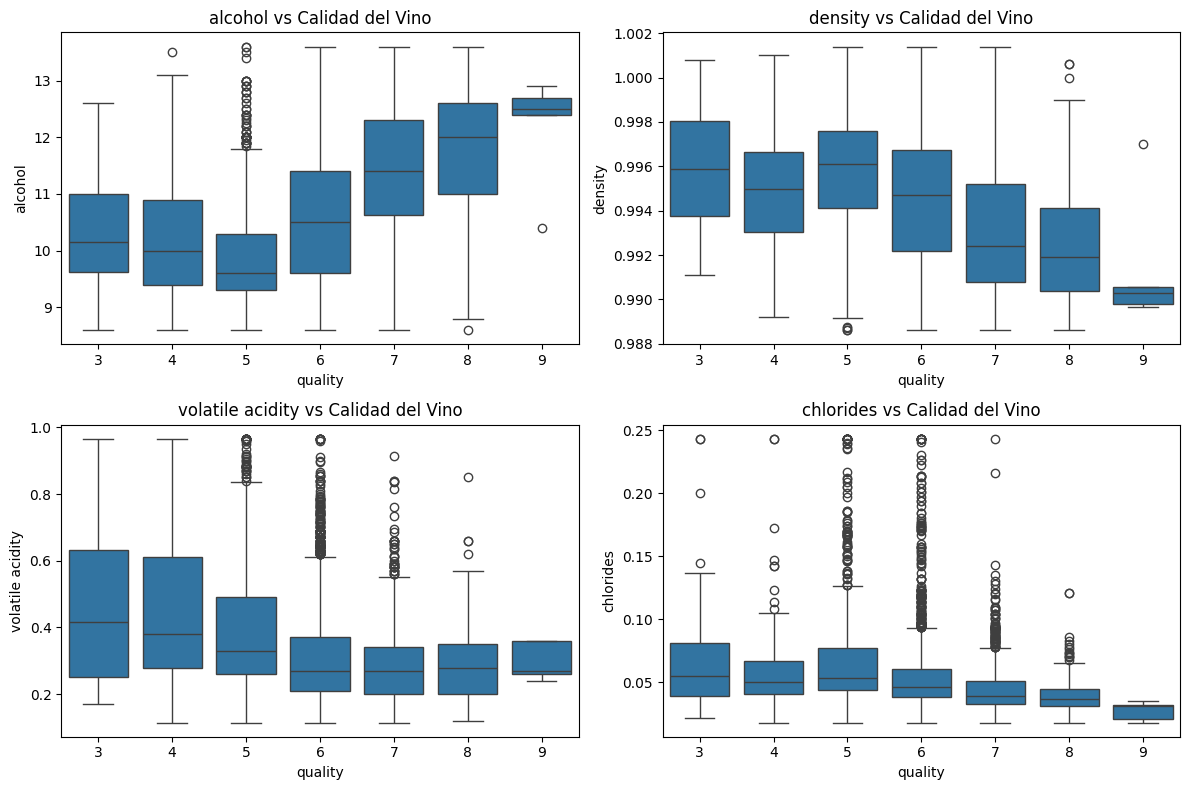

In [50]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=df_wine_quality_winsorized["quality"], y=df_wine_quality_winsorized[col])
    plt.title(f"{col} vs Calidad del Vino")
plt.tight_layout()
plt.show()


**4. Normalizar Variables Antes del Clustering**
- Objetivo: Escalar todas las variables a una misma escala para evitar sesgos en los modelos de clustering.
- Cómo hacerlo: Usar StandardScaler o MinMaxScaler.
  
**¿Qué buscamos?**

- Que todas las variables estén en la misma escala antes de hacer clustering.
- Que valores extremos no afecten demasiado el análisis.

In [51]:
df_wine_quality_winsorized.drop(columns=["quality", "type-wine"]).info()


<class 'pandas.core.frame.DataFrame'>
Index: 6497 entries, 0 to 4897
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
dtypes: float64(11)
memory usage: 867.1 KB


In [52]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Columnas que no queremos escalar ni incluir en el subset
columns_to_exclude = ["quality", "type-wine"]

# Creamos un DataFrame solo con las columnas numéricas que queremos escalar
df_to_scale = df_wine_quality_winsorized.drop(columns=columns_to_exclude)

# Aplicamos el escalado
scaled_features = scaler.fit_transform(df_to_scale)

# Reconstruimos el DataFrame escalado con los nombres originales
df_wine_scaled = pd.DataFrame(scaled_features, columns=df_to_scale.columns).reset_index(drop=True)

# Reincorporamos "quality" y "type-wine" sin modificar
df_wine_scaled["quality"] = df_wine_quality_winsorized["quality"].reset_index(drop=True)
df_wine_scaled["type-wine"] = df_wine_quality_winsorized["type-wine"].reset_index(drop=True)

df_wine_scaled.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type-wine
0,0.148729,2.227829,-2.233656,-0.756010,0.695206,-1.135417,-1.455384,1.065809,1.834983,0.210366,-0.918411,5,red
1,0.464214,3.339199,-2.233656,-0.605939,1.438509,-0.316214,-0.866886,0.723462,-0.115011,1.056911,-0.581653,5,red
2,0.464214,2.598286,-1.952629,-0.670255,1.235790,-0.901359,-1.098718,0.791931,0.262407,0.845275,-0.581653,5,red
3,3.145837,-0.365368,1.700713,-0.756010,0.661419,-0.784330,-0.991719,1.134279,-0.366623,0.351457,-0.581653,6,red
4,0.148729,2.227829,-2.233656,-0.756010,0.695206,-1.135417,-1.455384,1.065809,1.834983,0.210366,-0.918411,5,red


# Conclusiones del Análisis Exploratorio

## Distribución de la Calidad del Vino

- La mayoría de los vinos tienen una calidad entre **5 y 6**, lo que indica que el dataset está sesgado hacia valores intermedios.
- Existen muy pocos vinos con calidad **3 y 9**, lo que puede generar problemas si se quieren construir modelos de predicción, ya que estas clases están **desbalanceadas**.

---

## Matriz de Correlación

- **Alcohol** es la variable con mayor correlación positiva con la calidad del vino (~0.44), lo que sugiere que vinos con mayor contenido de **alcohol** tienden a tener mejor calidad.
- **Densidad** y **acidez volátil** tienen correlaciones negativas moderadas con la calidad del vino. Esto sugiere que vinos con menor **densidad** y menor **acidez volátil** tienden a ser de mejor calidad.
- **Cloruros** también presentan una correlación negativa con la calidad, lo que indica que **altos niveles de cloruros** podrían estar relacionados con vinos de menor calidad.
- Otras variables tienen correlaciones más débiles con la calidad.

---

## Distribución de Variables Clave

- **Alcohol:** Distribución sesgada a la derecha, con la mayoría de los valores entre **9 y 12.5**.
- **Densidad:** Tiene una distribución centrada en torno a **0.995**, lo que sugiere que la variabilidad en la densidad no es tan alta.
- **Acidez volátil:** Distribución sesgada a la derecha, con algunos valores extremos.
- **Cloruros:** También muestra una distribución sesgada con algunos valores atípicos.

---

## Boxplots de `quality` vs Variables Clave

- Se observa un **incremento** en el contenido de **alcohol** en los vinos de mayor calidad.
- La **densidad** parece **disminuir** en vinos de mayor calidad.
- La **acidez volátil** muestra una relación **inversa** con la calidad.
- El contenido de **cloruros** también es **menor** en vinos de mejor calidad.

---

## Estandarización de Datos

- Se aplicó **`StandardScaler`** para **normalizar** las variables antes de aplicar clustering.
- Ahora todas las variables tienen una **media de 0** y **desviación estándar de 1**, lo que es **esencial** para evitar sesgos en los modelos.
---

## Aplicación de Clustering para Identificar Patrones en la Calidad del Vino

Después de haber explorado la distribución de las variables y analizado sus relaciones con la calidad del vino, pasamos a aplicar **técnicas de clustering**. Estas técnicas nos permitirán agrupar los vinos según sus características químicas y ver si los vinos de mayor calidad comparten patrones comunes.

### ¿Por qué usamos clustering?
- **No tenemos etiquetas explícitas**: Aunque tenemos una variable de calidad, queremos descubrir patrones en las características sin imponer una segmentación previa.
- **Ayuda a descubrir grupos naturales**: Nos permite identificar segmentos de vinos con propiedades similares, lo que puede ayudar a comprender qué define un vino de mayor calidad.
- **Puede mejorar modelos predictivos**: Si encontramos grupos bien diferenciados, esto podría servir como una nueva característica para futuros modelos de clasificación.

### ¿Qué técnica usaremos?
Para este análisis, aplicaremos **K-Means**, una de las técnicas más utilizadas en clustering. Usaremos el **método del codo** para determinar el número óptimo de clusters y posteriormente evaluaremos la separación de los grupos utilizando la métrica de **silhouette score**.



In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D  # Para visualización en 3D

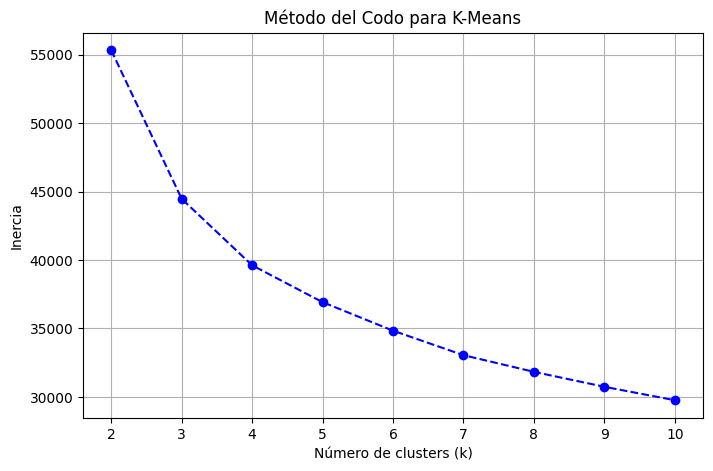

In [54]:
# Definir un rango de posibles clusters
k_values = range(2, 11)  # Probamos de 2 a 10 clusters
inertia_values = []  # Aquí guardaremos la inercia para cada k

# Aplicamos K-Means para cada valor de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_wine_scaled.drop(columns=['quality', 'type-wine']))  # Aplicamos sobre datos sin la columna "quality"
    inertia_values.append(kmeans.inertia_)  # Guardamos la inercia

# Visualizamos el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker="o", linestyle="--", color="b")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.title("Método del Codo para K-Means")
plt.grid(True)
plt.show()

In [55]:
# Elegimos k óptimo basado en la gráfica anterior (suponiendo k=4)
optimal_k = 4  # Ajustar este valor según el método del codo

# Aplicamos K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_wine_scaled["cluster"] = kmeans.fit_predict(df_wine_scaled.drop(columns=["quality", 'type-wine']))  # Guardamos los clusters en el DataFrame

# Visualizamos el tamaño de cada cluster
df_wine_scaled["cluster"].value_counts()


cluster
1    2923
2    1869
0     998
3     707
Name: count, dtype: int64

In [56]:
# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(df_wine_scaled.drop(columns=["quality", "cluster",'type-wine']), df_wine_scaled["cluster"])
print(f"Coeficiente de silueta para k={optimal_k}: {silhouette_avg:.3f}")

Coeficiente de silueta para k=4: 0.250


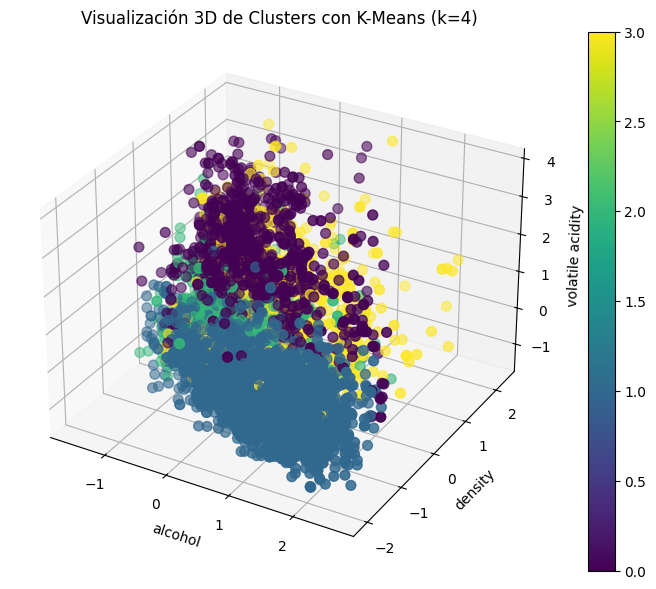

In [57]:
# Seleccionamos tres variables importantes para la visualización
features_3d = ["alcohol", "density", "volatile acidity"]

# Creamos la figura 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot en 3D con colores según los clusters
scatter = ax.scatter(df_wine_scaled[features_3d[0]], 
                     df_wine_scaled[features_3d[1]], 
                     df_wine_scaled[features_3d[2]], 
                     c=df_wine_scaled["cluster"], cmap="viridis", s=50)

# Etiquetas de los ejes
ax.set_xlabel(features_3d[0])
ax.set_ylabel(features_3d[1])
ax.set_zlabel(features_3d[2])
ax.set_title(f"Visualización 3D de Clusters con K-Means (k={optimal_k})")

# Agregar barra de colores
plt.colorbar(scatter, ax=ax)
plt.show()

## ¿Por qué no elegimos K-Means?

Tras aplicar el **método del codo**, determinamos que **k = 4** era un valor óptimo para segmentar los vinos. Sin embargo, al calcular el **coeficiente de silueta** (*0.25*), observamos que los clusters no estaban bien separados y presentaban una superposición significativa.

### Limitaciones de K-Means en este caso:
- **Baja separación de clusters**: Un coeficiente de silueta bajo indica que los grupos encontrados no son claramente distintos.
- **Distribución difusa en 3D**: La visualización tridimensional mostró que los clusters no tienen fronteras bien definidas.
- **Limitaciones de la distancia euclidiana**: K-Means asume que los clusters son esféricos y equidistantes, lo cual no parece ser el caso en nuestros datos.

### Próximos pasos: Exploración de alternativas
Para mejorar la segmentación, exploraremos técnicas más avanzadas como:
- **PCA (Análisis de Componentes Principales)**: Para reducir la dimensionalidad y visualizar mejor la estructura de los datos.  
- **DBSCAN**: Un algoritmo basado en densidad que puede detectar mejor grupos de diferentes formas y tamaños, lo que podría ser más adecuado para identificar patrones ocultos en los vinos.  

---

## ¿Por qué usamos PCA y cuál es el objetivo?

El **Análisis de Componentes Principales (PCA)** es una técnica de reducción de dimensionalidad que nos permite transformar un conjunto de variables correlacionadas en un nuevo conjunto de variables **no correlacionadas**, llamadas **componentes principales**.

### ¿Por qué aplicamos PCA en nuestro análisis?
- **Reducción de dimensionalidad**: Nuestros datos contienen múltiples variables químicas del vino, y PCA nos ayuda a reducir su número sin perder información clave.  
- **Eliminación de redundancia**: Muchas variables están correlacionadas, y PCA permite capturar la mayor varianza en menos componentes.  
- **Visualización de los datos**: Al reducir los datos a **dos componentes principales**, podemos graficarlos en 2D y analizar su estructura de manera más intuitiva.  

### Objetivo del PCA en este estudio:
- Convertir las múltiples variables en **dos componentes principales** para facilitar la interpretación.  
- **Identificar patrones y separaciones** entre los vinos según sus características.  
- Facilitar la aplicación de algoritmos de clustering, asegurando que las dimensiones relevantes sean utilizadas de manera eficiente.  


In [58]:
# Importar librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Definir el número de componentes principales
n_components = 2  # Queremos reducir los datos a 2 dimensiones

# Aplicamos PCA
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(df_wine_scaled.drop(columns=["quality", "cluster", 'type-wine']))

# Convertimos a DataFrame para visualizar
df_pca = pd.DataFrame(principal_components, columns=[f"PC{i+1}" for i in range(n_components)])
df_pca["cluster"] = df_wine_scaled["cluster"]  # Agregamos la columna de clusters para ver su distribución

df_pca.head()

,PC1,PC2,cluster
0,-3.341572,0.369653,0
1,-3.233371,1.095730,0
2,-3.247444,0.848391,0
3,-1.715867,2.092895,3
4,-3.341572,0.369653,0


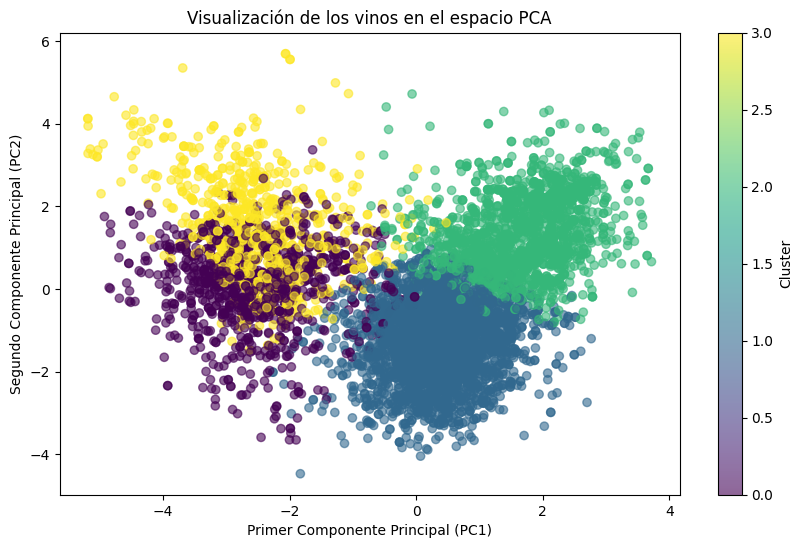

In [59]:
# Visualización en 2D de los componentes principales
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_pca["PC1"], df_pca["PC2"], c=df_pca["cluster"], cmap="viridis", alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("Primer Componente Principal (PC1)")
plt.ylabel("Segundo Componente Principal (PC2)")
plt.title("Visualización de los vinos en el espacio PCA")
plt.show()

In [60]:
# Varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Mostrar la varianza explicada
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f} ({var*100:.2f}%)")

PC1: 0.2835 (28.35%)
PC2: 0.2297 (22.97%)


## Conclusiones del análisis con PCA

El **Análisis de Componentes Principales (PCA)** logró reducir la dimensionalidad de los datos, **conservando más del 50% de la varianza total**, distribuyéndose de la siguiente manera:

- **Primer componente principal (PC1):** Explica el **28.35%** de la varianza.
- **Segundo componente principal (PC2):** Explica el **22.97%** de la varianza.

### ¿Qué nos indica la visualización en el espacio PCA?
- **Patrones diferenciados:** Se observa que los vinos tienden a agruparse en diferentes zonas, lo que sugiere que sus características químicas presentan cierta estructura subyacente.  
- **Separación parcial:** Aunque se identifican agrupaciones, **algunos clusters no están completamente diferenciados**, lo que indica que las variables originales aún contienen información relevante.  
- **Posible necesidad de más componentes:** Si bien PCA ha permitido visualizar mejor la relación entre los vinos, puede ser necesario considerar **más componentes** para mejorar la representación y separación de los grupos.  

### ¿Por qué es útil este análisis?
Este análisis nos ayuda a explorar la **estructura oculta en los datos** y evaluar si el **clustering aplicado** es realmente adecuado para segmentar la calidad del vino. A partir de esta reducción de dimensionalidad, podemos mejorar los algoritmos de clustering y validar su desempeño en la clasificación de los vinos. 

---

### Construcción y Evaluación del Modelo Predictivo
En los análisis previos, exploramos los datos mediante clustering y PCA con el objetivo de identificar patrones ocultos en la calidad del vino. Sin embargo, los resultados indicaron que la segmentación mediante clustering no proporcionaba una separación clara entre vinos de distintas calidades. Por ello, optamos por un modelo supervisado que permita predecir directamente la variable quality a partir de sus características químicas.



#### Regresión Lineal

La regresión lineal es un método estadístico y de Machine Learning que busca modelar la relación entre una variable objetivo (o dependiente) $y$ y una o más variables predictoras (o independientes) $X_1, X_2, \dots, X_n$. El modelo asume que la variable objetivo puede expresarse como una combinación lineal de los predictores, más un término de error:

$$
y \approx \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n
$$

##### 1. ¿Qué es hacer una regresión lineal?
- **Objetivo:** Encontrar los coeficientes $\beta_0, \beta_1, \dots, \beta_n$ que mejor expliquen la relación entre los predictores y la variable objetivo.
- **Método de ajuste:** Se ajusta el modelo minimizando la suma de los errores cuadrados (a través del método de Mínimos Cuadrados Ordinarios) u otra función de costo.

##### 2. ¿Cómo se obtiene?
- **Resolución de ecuaciones:** En la forma clásica, se obtienen los coeficientes resolviendo las ecuaciones que minimizan la suma de los cuadrados de los residuos (la diferencia entre los valores reales y los valores predichos).
- **Implementación práctica:** Utilizando bibliotecas de Machine Learning (por ejemplo, `scikit-learn` en Python), el modelo se ajusta mediante métodos numéricos que calculan los coeficientes $\beta$.
- **Manejo de múltiples variables:** En el caso de múltiples variables, se pueden utilizar técnicas de regularización (como Ridge o Lasso) para controlar el sobreajuste y la multicolinealidad.

##### 3. ¿Qué se espera obtener?
- **Modelo interpretativo:** Permite entender cómo cada variable independiente influye en la variable objetivo. Cada coeficiente $\beta_i$ indica el cambio en $y$ ante un cambio unitario en $X_i$.
- **Predicciones para nuevos datos:** Una vez ajustado, el modelo puede utilizarse para predecir el valor de $y$ al introducir nuevos valores de $X_1, X_2, \dots, X_n$.
- **Evaluación del desempeño:** Se utilizan métricas como RMSE (Error Cuadrático Medio) y MAE (Error Absoluto Medio) para medir la precisión del modelo y su capacidad de generalización.

### Aplicación en la Calidad del Vino
En el contexto de la calidad del vino, la regresión lineal se utiliza para:
- Relacionar las características fisicoquímicas (por ejemplo, acidez, pH, alcohol, etc.) con la calificación de calidad ($quality$).
- Identificar cuáles variables tienen mayor impacto en la calidad del vino.
- Estimar el valor de $quality$ para nuevos vinos, permitiendo predecir la calidad con un modelo simple y fácilmente interpretativo.


In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Copiamos el dataframe original
df_wine_predictive_quality = df_wine_quality_winsorized.copy()

# Definir X e y para la regresión lineal eliminando las columnas no numéricas o irrelevantes
# Se eliminan "quality", "type-wine", "date_column" y "array_column"
X = df_wine_predictive_quality.drop(columns=["quality", "type-wine"])
y = df_wine_predictive_quality["quality"]

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [62]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

In [63]:
from sklearn.metrics import mean_absolute_error
#Evaluamos el modelo para ver como de bien predice la calidad del vino
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Mean Absolute Error (MAE): 0.57


In [64]:
#Evaluamos la estabilidad del modelo
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Squared Error (MSE): 0.54
Root Mean Squared Error (RMSE): 0.73


In [65]:
# valores cercanos a 1 es un buen ajuste, cercano a 0 es negativo
r2 = model.score(X_test, y_test)
print(f"R² Score: {r2:.2f}")

R² Score: 0.27


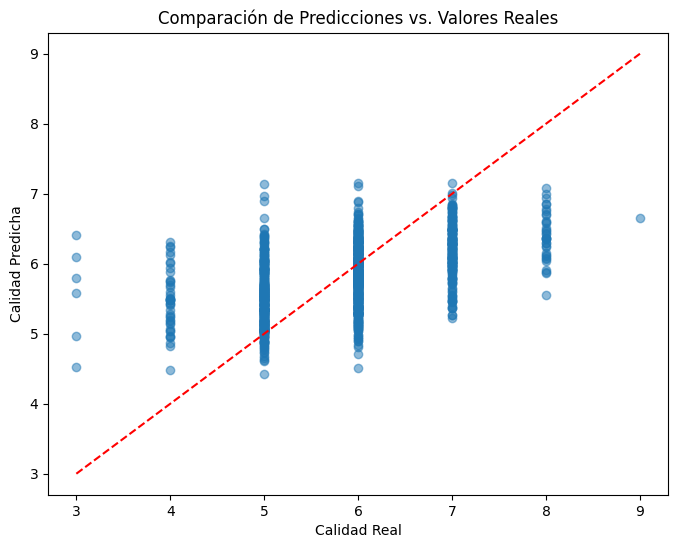

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="dashed")  # Línea de referencia ideal
plt.xlabel("Calidad Real")
plt.ylabel("Calidad Predicha")
plt.title("Comparación de Predicciones vs. Valores Reales")
plt.show()

In [67]:
#entendemos cómo cada variable afecta la predicción de la calidad del vino:
coefficients = pd.DataFrame(model.coef_, X_train.columns, columns=['Coeficiente'])
coefficients = coefficients.sort_values(by="Coeficiente", ascending=False)
print(coefficients)


                      Coeficiente
sulphates                0.908267
pH                       0.500449
alcohol                  0.259972
fixed acidity            0.086814
residual sugar           0.049187
free sulfur dioxide      0.007844
chlorides                0.004973
total sulfur dioxide    -0.002774
citric acid             -0.142437
volatile acidity        -1.330776
density                -70.278954


### Conclusiones 

El modelo de regresión lineal tiene un poder predictivo bajo (R^2
 =0.27), lo que indica que solo explica el 27% de la variabilidad en la calidad del vino. Factores como sulphates, pH y alcohol tienen un impacto positivo en la calidad, mientras que density y volatile acidity la reducen. Sin embargo, la dispersión en la gráfica de predicciones muestra que el modelo no capta bien los patrones. Se recomienda explorar modelos más avanzados como Random Forest o XGBoost para mejorar la precisión

---

## Regresión Logística

La **Regresión Logística** es un modelo estadístico utilizado para predecir variables categóricas, especialmente cuando la variable objetivo tiene solo dos posibles valores (**clasificación binaria**). En este caso, queremos clasificar los vinos en dos categorías:

- **Alta calidad** (`quality > 7`, representado como `1`).
- **Baja calidad** (`quality ≤ 7`, representado como `0`).

A diferencia de la **Regresión Lineal**, que predice valores continuos, la **Regresión Logística** estima la **probabilidad** de que una observación pertenezca a una clase específica. Para ello, en lugar de una función lineal simple, la regresión logística aplica la función **sigmoide** para convertir las predicciones en probabilidades entre `0` y `1`.

### **1. Fórmula Matemática de la Regresión Logística**
La relación entre las variables predictoras y la variable objetivo se modela con la siguiente ecuación:

$$
y \approx \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n
$$

Sin embargo, como queremos predecir probabilidades en lugar de valores continuos, aplicamos la función sigmoide \( \sigma(z) \):

$$
P(y=1 | X) = \sigma(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n)
$$

donde la **función sigmoide** es:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Esto asegura que la salida siempre esté en el rango \( [0,1] \), lo que nos permite interpretarla como una probabilidad.

---

### **2. ¿Qué se espera obtener con la Regresión Logística?**
Al aplicar este modelo, buscamos:

- **Identificar las variables más influyentes en la calidad del vino.**  
  - ¿El contenido de alcohol tiene una relación directa con la calidad?  
  - ¿Factores como la acidez o el pH impactan en la percepción del vino?  

- **Predecir si un vino es de alta o baja calidad basado en sus características fisicoquímicas.**  
  - La salida del modelo será una **probabilidad**.  
  - Si \( P(y=1) \) es mayor a un umbral (generalmente 0.5), clasificamos el vino como **alta calidad** (`1`).  

- **Evaluar la precisión del modelo** mediante métricas como:
  - **Exactitud (Accuracy):** Porcentaje de predicciones correctas.  
  - **Matriz de Confusión:** Para visualizar falsos positivos y falsos negativos.  
  - **ROC-AUC Score:** Para medir qué tan bien el modelo distingue entre las clases.  

---

### **3. Diferencias con la Regresión Lineal**
| Característica            | Regresión Lineal                        | Regresión Logística                      |
|---------------------------|----------------------------------------|-----------------------------------------|
| **Tipo de variable objetivo** | Continua (números reales)             | Categórica (binaria: 0 o 1)             |
| **Función aplicada**       | Línea recta                           | Función sigmoide                       |
| **Salida del modelo**      | Valor numérico                        | Probabilidad de pertenecer a una clase |
| **Interpretación**         | Cambios absolutos en `y` por `X_i`    | Probabilidad de pertenecer a `y=1`     |

---

### **4. Aplicación en la Calidad del Vino**
En este análisis, la **Regresión Logística** nos ayudará a:

- **Determinar qué características del vino están asociadas con una alta calidad (`quality > 7`).**  
- **Predecir si un vino es de alta calidad a partir de sus características fisicoquímicas.**  
- **Evaluar si los vinos tintos y blancos presentan diferencias significativas en su calidad percibida.**  
 


In [68]:
# Primero preparamos los datos y determinamos qué caracteriza a un vino de buena o mala calidad
# Si quality > 7 le damos valor 1, si quality ≤ 7 le damos valor 0

# Copiamos el dataframe original
df_wine_predictive_quality = df_wine_quality_winsorized.copy()

# Aplicamos la transformación binaria a quality
df_wine_predictive_quality['quality_binary'] = df_wine_predictive_quality['quality'].apply(lambda x: 1 if x >= 7 else 0)

# Verificamos el resultado con un muestreo
print(df_wine_predictive_quality[['quality', 'quality_binary']].sample(5))

# Verificamos la distribución de las clases
print(df_wine_predictive_quality['quality_binary'].value_counts())



      quality  quality_binary
1753        7               1
2078        6               0
2405        5               0
861         7               1
880         5               0
quality_binary
0    5220
1    1277
Name: count, dtype: int64



### **Observaciones sobre la Distribución de Clases**
Podemos observar un **desbalance en los datos**:
- La mayoría de los vinos tienen **baja calidad** (`quality_binary = 0`), con **5220 muestras**.
- Solo **1277 muestras** corresponden a vinos de **alta calidad** (`quality_binary = 1`).
- Esto implica que **aproximadamente el 30% de los datos pertenecen a la clase minoritaria** (`quality > 7`).

### **Impacto del Desbalance en el Modelo**
El desbalance de clases puede afectar el rendimiento del modelo de clasificación:
- **Predicciones sesgadas:** Si una clase es mucho más frecuente que la otra, el modelo puede aprender a predecir mayormente la clase más común (`0`), ignorando la minoritaria.
- **Riesgo de baja capacidad de generalización:** Un modelo altamente sesgado podría no identificar correctamente los vinos de alta calidad.
- **Métricas engañosas:** La exactitud (`accuracy`) del modelo podría parecer alta si simplemente predice la clase mayoritaria, sin realmente capturar patrones útiles en los datos.

---

### División en Conjuntos de Entrenamiento y Prueba
Ahora vamos a dividir nuestro conjunto de datos en entrenamiento (80%) y prueba (20%). Esto nos permitirá entrenar el modelo con la mayor parte de los datos y luego evaluar su desempeño en datos que no ha visto antes.

##### ¿Por qué hacemos esta división?
Evitar el sobreajuste `(overfitting)`: Si entrenamos y evaluamos el modelo en los mismos datos, este podría "memorizar" los datos en lugar de aprender patrones generales.
**Evaluación realista**: Al usar datos de prueba que no fueron usados para entrenar, obtenemos una mejor idea de cómo se comportará el modelo en situaciones reales.
Generalización: Nos aseguramos de que el modelo pueda hacer predicciones en datos nuevos y no solo en los datos de entrenamiento.


In [69]:
# Convertimos 'type-wine' en variables numéricas con One-Hot Encoding
df_encoded = pd.get_dummies(df_wine_predictive_quality, columns=["type-wine"], drop_first=True)

# Separar X e y
X = df_encoded.drop(columns=["quality", "quality_binary"])
y = df_encoded["quality_binary"]

# Verificamos la estructura de X e y
print(X.shape, y.shape)


(6497, 12) (6497,)


¿Qué hace pd.get_dummies()?
Convierte variables categóricas en variables numéricas.
Como type-wine tiene dos valores posibles ("red" y "white"), se crea una columna binaria.
drop_first=True elimina una de las categorías para evitar colinealidad en el modelo.

In [70]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificamos las dimensiones de los conjuntos resultantes
print(f"Tamaño de X_train: {X_train.shape}, Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}, Tamaño de y_test: {y_test.shape}")


Tamaño de X_train: (5197, 12), Tamaño de y_train: (5197,)
Tamaño de X_test: (1300, 12), Tamaño de y_test: (1300,)


Se realizó una división de los datos en entrenamiento (80%) y prueba (20%).
X_train (entrenamiento): 5197 muestras con 14 características.
X_test (prueba): 1300 muestras con 14 características.
y_train: 5197 etiquetas correspondientes a los datos de entrenamiento.
y_test: 1300 etiquetas para evaluar el modelo

##### Primero entrenaremos a nuestro modelo

In [71]:
print(X_train.dtypes)

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
type-wine_white            bool
dtype: object


In [72]:
X_train["type-wine_white"] = X_train["type-wine_white"].astype(int)
X_test["type-wine_white"] = X_test["type-wine_white"].astype(int)

In [73]:
print(X_train.dtypes)

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
type-wine_white           int64
dtype: object


In [74]:
from sklearn.linear_model import LogisticRegression

# Crear el modelo de regresión logística
model = LogisticRegression(max_iter=1000, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

C:\Users\Oscar\anaconda3\envs\PC1\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

##### Error: El optimizador L-BFGS no ha convergido

Al entrenar el modelo de **Regresión Logística**, se ha producido el siguiente error:

> **El optimizador L-BFGS no ha logrado converger en el número máximo de iteraciones (`max_iter=1000`)**, lo que significa que el modelo no ha podido encontrar una solución óptima.

##### **¿Por qué ocurre este problema?**
Existen varias razones por las cuales la optimización de la Regresión Logística puede no converger:

1. **Los datos no están escalados**  
   - La **Regresión Logística es sensible a las escalas de las variables**.  
   - Si las características tienen rangos muy diferentes (por ejemplo, `pH` entre **3-4** y `sulfatos` entre **0.3-1.5**), el optimizador puede tener problemas para converger.  
   - **Solución:** Aplicar escalado estándar con `StandardScaler` de `sklearn`.  

2. **Pocas iteraciones (`max_iter=1000`)**  
   - En algunos casos, el modelo necesita más iteraciones para encontrar la mejor solución.  
   - **Solución:** Aumentar el número de iteraciones (`max_iter=5000` o más) para permitir que el optimizador siga buscando una solución óptima.  

3. **Colinealidad o valores extremos en las variables**  
   - Algunas variables pueden estar altamente correlacionadas, lo que puede dificultar el entrenamiento del modelo.  
   - La presencia de **valores extremos (outliers)** también puede hacer que la optimización no sea estable.  
   - **Solución:**  
     - Revisar la matriz de correlación para detectar variables redundantes.  
     - Aplicar técnicas como **reducción de dimensionalidad** (PCA) o **eliminación de variables altamente correlacionadas**.  

Para evitar este problemavamos a normalizar los datos con StandardScaler.

La mejor práctica en regresión logística es escalar los datos para que todas las variables tengan una media de 0 y una desviación estándar de 1:


In [75]:
from sklearn.preprocessing import StandardScaler

# Aplicar StandardScaler a los datos de entrada
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [76]:
from sklearn.linear_model import LogisticRegression

# Crear el modelo de regresión logística
model = LogisticRegression(max_iter=2000, random_state=42, class_weight="balanced")

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

In [77]:
y_pred = model.predict(X_test_scaled)

In [78]:
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.7123
F1-Score: 0.5053


### Evaluación del Modelo de Regresión Logística

Hemos probado dos versiones del modelo de **Regresión Logística**:  
1. **Sin balanceo de clases (`class_weight` por defecto)**  
2.  **Con balanceo automático de clases (`class_weight='balanced'`)**

A continuación, se presentan los resultados:

| Modelo | Accuracy | F1-Score |
|--------|----------|----------|
| **Sin balanceo (`class_weight` por defecto)** | 0.8331 | 0.4119 |
| **Con balanceo (`class_weight='balanced'`)** | 0.7123 | 0.5053 |

##### **Análisis de los resultados**
- **Sin balanceo (`class_weight` por defecto)**
  - Se obtiene una **alta exactitud (accuracy = 83.31%)**, pero esto es engañoso.
  - El modelo prioriza la **clase mayoritaria** (vinos de baja calidad) y tiene dificultades para identificar los vinos de alta calidad.
  - Esto se refleja en un **F1-Score bajo (0.4119)**, indicando que la capacidad del modelo para detectar correctamente la clase minoritaria es deficiente.

- **Con balanceo (`class_weight='balanced'`)**
  - La **accuracy baja a 71.23%**, ya que el modelo ya no predice solo la clase mayoritaria.
  - Sin embargo, el **F1-Score mejora a 0.5053**, lo que significa que ahora el modelo es más efectivo en la detección de vinos de alta calidad.
  - Aunque la exactitud general ha disminuido, el modelo ahora tiene una mejor capacidad de generalización para ambas clases.

---

In [79]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)


Matriz de Confusión:
[[735 313]
 [ 61 191]]


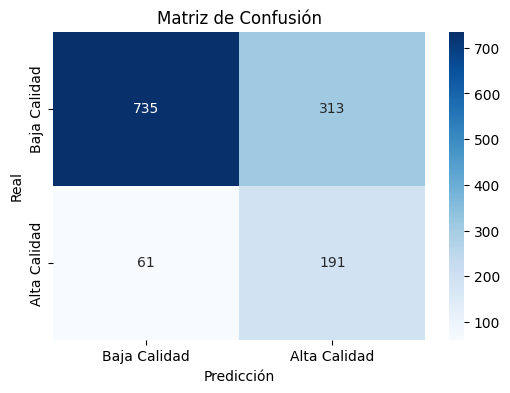

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizar la matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Baja Calidad", "Alta Calidad"], yticklabels=["Baja Calidad", "Alta Calidad"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


#### **Visualización de la Matriz de Confusión**
Para analizar mejor el rendimiento del modelo, utilizaremos la **Matriz de Confusión**, que nos permite visualizar cómo se están clasificando las muestras:

| **Predicción Negativa (0)** | **Predicción Positiva (1)** |
|-----------------------------|-----------------------------|
| **Real Negativa (0)** | **TN (Verdaderos Negativos)** | **FP (Falsos Positivos)** |
| **Real Positiva (1)** | **FN (Falsos Negativos)** | **TP (Verdaderos Positivos)** |

#### **¿Qué significa cada término?**
- **TN (Verdaderos Negativos):** Vinos de baja calidad correctamente clasificados como `0`.
- **FP (Falsos Positivos):** Vinos de baja calidad incorrectamente clasificados como `1`.
- **FN (Falsos Negativos):** Vinos de alta calidad incorrectamente clasificados como `0`.
- **TP (Verdaderos Positivos):** Vinos de alta calidad correctamente clasificados como `1`.

---

#### **Conclusión**
- **Si nuestro objetivo es identificar con precisión los vinos de alta calidad**, el **F1-Score** es la métrica más importante, ya que equilibra precisión y recall.
- **El balanceo de clases (`class_weight='balanced'`) ayuda a mejorar la detección de la clase minoritaria**, aunque a costa de reducir la exactitud global.
- **El siguiente paso** es visualizar la matriz de confusión para entender mejor dónde el modelo está fallando y ajustar hiperparámetros o probar otros algoritmos (p. ej., **árboles de decisión o Random Forest**) para mejorar el rendimiento.


 Accuracy: 0.7723
 F1-Score: 0.5210


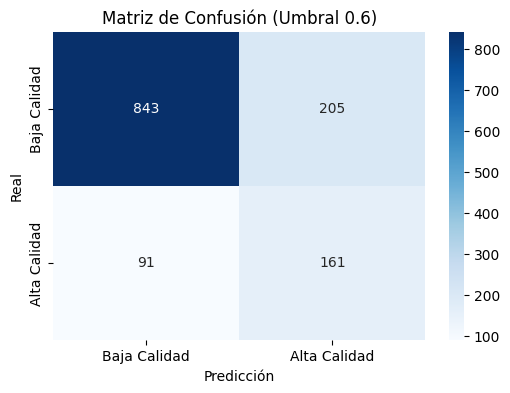

In [81]:
#  Predecimos probabilidades en vez de clases
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Tomamos solo la probabilidad de la clase positiva (1)

#  Ajustamos el umbral de clasificación a 0.6 (más conservador)
threshold = 0.6
y_pred_adjusted = (y_proba > threshold).astype(int)

#  Evaluamos las métricas de clasificación con el nuevo umbral
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = accuracy_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)

print(f" Accuracy: {accuracy:.4f}")
print(f" F1-Score: {f1:.4f}")

#  Matriz de confusión con el nuevo umbral
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

#  Visualización de la matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Baja Calidad", "Alta Calidad"], yticklabels=["Baja Calidad", "Alta Calidad"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión (Umbral {threshold})")
plt.show()


Hemos evaluado el modelo con la **matriz de confusión estándar (umbral 0.5)** para obtener una referencia inicial, pero observamos que tenía dificultades para identificar los vinos de alta calidad. Por ello, ajustamos el umbral a **0.6** para mejorar la precisión en la detección de la clase minoritaria, aunque los resultados siguen sin ser óptimos. Dado que la Regresión Logística no logra una separación clara entre clases, ahora probaremos un **DecisionTreeClassifier**, que puede capturar relaciones no lineales en los datos y mejorar la clasificación. 


### Predicción de la Calidad del Vino utilizando Árboles de Decisión

Hasta ahora, hemos intentado clasificar los vinos en categorías de **alta y baja calidad** utilizando **Regresión Logística**, pero los resultados han demostrado que este enfoque no logra capturar completamente la complejidad de los datos. Además, ajustar el umbral de clasificación solo ha generado mejoras marginales en la detección de la clase minoritaria.

Por ello, en este paso, exploraremos un enfoque diferente: **predecir directamente la calidad del vino (quality) como una variable categórica**, en lugar de una simple clasificación binaria. Para ello, utilizaremos **Árboles de Decisión**, una técnica de Machine Learning que permite capturar relaciones no lineales entre las características físico-químicas del vino y su calidad.

Los Árboles de Decisión tienen varias ventajas en este contexto:
- Son interpretables y permiten entender qué factores influyen más en la calidad del vino.  
- Pueden manejar relaciones no lineales entre las variables.  
- No requieren que las características sean escaladas, a diferencia de la Regresión Logística.  

En este proceso, tomaremos los valores originales de la variable `quality` y entrenaremos un **DecisionTreeClassifier** para analizar si podemos encontrar patrones más representativos y mejorar la predicción de la calidad del vino. 


Error Absoluto Medio (MAE): 0.5754
Error Cuadrático Medio (MSE): 0.7646
Raíz del Error Cuadrático Medio (RMSE): 0.8744
Precisión del modelo (Accuracy): 51.15%
Número total de muestras: 1300
Aciertos exactos: 665 (51.15%)
Errores exactos: 635 (48.85%)


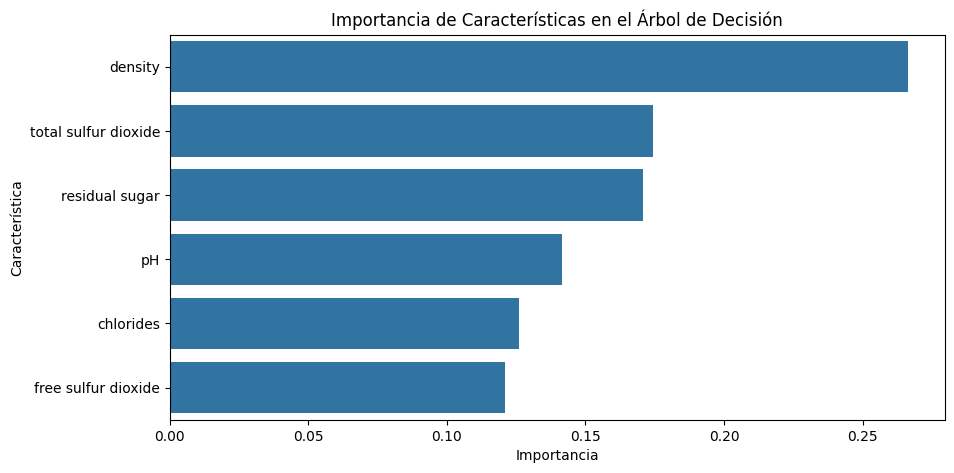

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

# 1️ Copiar el dataset original para no modificarlo
df_wine_copy = df_wine_quality.copy()

# 2️ Seleccionar solo las características más relevantes según la importancia de variables previa
selected_features = ["chlorides", "residual sugar", "free sulfur dioxide", 
                     "density", "pH", "total sulfur dioxide"]
X_selected = df_wine_copy[selected_features]
y = df_wine_copy["quality"]

# 3️ Codificar la variable objetivo `y`
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 4️ Dividir en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42)

# 5️ Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6️ Entrenar el modelo con el mejor ajuste
best_tree_model = DecisionTreeClassifier(max_depth=10, random_state=42)
best_tree_model.fit(X_train_scaled, y_train)

# 7️ Obtener predicciones en el conjunto de prueba
y_pred = best_tree_model.predict(X_test_scaled)

# 8️ Evaluar el modelo con métricas de error
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
accuracy = accuracy_score(y_test, y_pred)

print(f"Error Absoluto Medio (MAE): {mae:.4f}")
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")
print(f"Precisión del modelo (Accuracy): {accuracy * 100:.2f}%")

# 9️ Mostrar total de muestras y errores directos sin margen de tolerancia
total_muestras = len(y_test)
errores_directos = (y_pred != y_test).sum()
aciertos_directos = total_muestras - errores_directos

print(f"Número total de muestras: {total_muestras}")
print(f"Aciertos exactos: {aciertos_directos} ({(aciertos_directos / total_muestras) * 100:.2f}%)")
print(f"Errores exactos: {errores_directos} ({(errores_directos / total_muestras) * 100:.2f}%)")

# 10️ Visualizar Importancia de Características
importances = best_tree_model.feature_importances_
importance_df = pd.DataFrame({"Característica": X_selected.columns, "Importancia": importances})
importance_df = importance_df.sort_values(by="Importancia", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x="Importancia", y="Característica", data=importance_df)
plt.title("Importancia de Características en el Árbol de Decisión")
plt.show()


 Error Absoluto Medio (MAE): 0.5754
 Error Cuadrático Medio (MSE): 0.7646
 Raíz del Error Cuadrático Medio (RMSE): 0.8744
Número total de muestras: 1300
Aciertos dentro del margen ±1: 1197 (92.08%)
Errores fuera del margen ±1: 103 (7.92%)


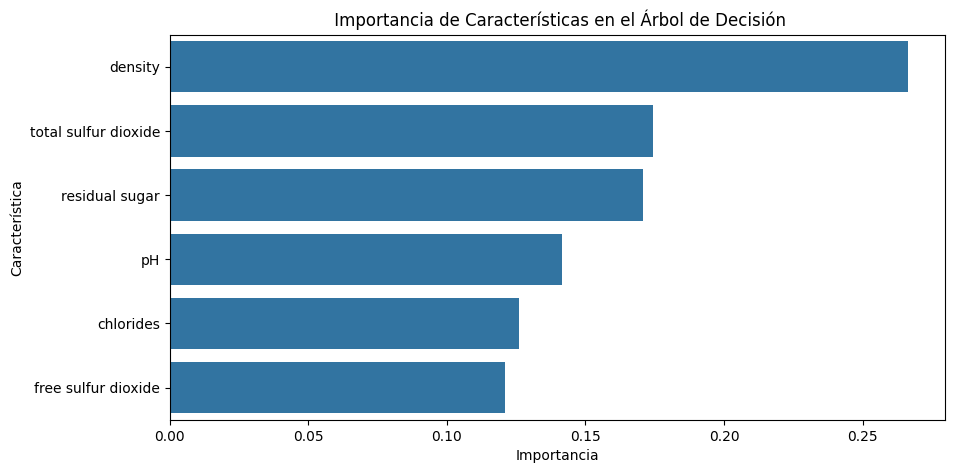

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1️ Copiar el dataset original para no modificarlo
df_wine_copy = df_wine_quality.copy()

# 2️ Seleccionar solo las características más relevantes según la importancia de variables previa
selected_features = ["chlorides", "residual sugar", "free sulfur dioxide", 
                     "density", "pH", "total sulfur dioxide"]
X_selected = df_wine_copy[selected_features]
y = df_wine_copy["quality"]

# 3️ Codificar la variable objetivo `y` (ya que tiene valores categóricos)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 4️ Dividir en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42)

# 5️ Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6️ Entrenar el modelo con el mejor ajuste
best_tree_model = DecisionTreeClassifier(max_depth=10, random_state=42)
best_tree_model.fit(X_train_scaled, y_train)

# 7️ Obtener predicciones en el conjunto de prueba
y_pred = best_tree_model.predict(X_test_scaled)

# 8️ Evaluar el modelo con métricas de error
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f" Error Absoluto Medio (MAE): {mae:.4f}")
print(f" Error Cuadrático Medio (MSE): {mse:.4f}")
print(f" Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")

# 9️ Evaluación con margen de error ±1 (es decir, permitir que el modelo prediga con un pequeño error)
total = len(y_test)
aciertos_relajados = ((y_pred >= (y_test - 1)) & (y_pred <= (y_test + 1))).sum()
errores_relajados = total - aciertos_relajados

# Mostrar resultados
print(f"Número total de muestras: {total}")
print(f"Aciertos dentro del margen ±1: {aciertos_relajados} ({(aciertos_relajados / total) * 100:.2f}%)")
print(f"Errores fuera del margen ±1: {errores_relajados} ({(errores_relajados / total) * 100:.2f}%)")

#  Visualizar Importancia de Características
importances = best_tree_model.feature_importances_
importance_df = pd.DataFrame({"Característica": X_selected.columns, "Importancia": importances})
importance_df = importance_df.sort_values(by="Importancia", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x="Importancia", y="Característica", data=importance_df)
plt.title(" Importancia de Características en el Árbol de Decisión")
plt.show()


# Conclusión Final del Proyecto

En este análisis sobre la **calidad del vino**, hemos aplicado distintos modelos de **aprendizaje automático** para predecir la variable `quality`. A lo largo del proceso, hemos llevado a cabo experimentos, ajustes y análisis detallados que nos han permitido extraer conclusiones clave sobre los factores que influyen en la calidad del vino y la capacidad de los modelos para predecirla.

---

##  Preprocesamiento y Selección de Variables

- Inicialmente, seleccionamos las características más relevantes basándonos en su importancia en distintos modelos:
  - `alcohol`,`chlorides`, `residual sugar`, `free sulfur dioxide`, `density`, `pH`, `total sulfur dioxide`.
- Observamos que la relevancia de estas variables varía según el modelo utilizado, lo que sugiere que **la calidad del vino no depende de un único patrón objetivo**, sino de una combinación de factores.

---


##  Evaluación de Resultados

- **La precisión del mejor modelo no superó el 51%**, lo que indica que la variable `quality` tiene un alto grado de subjetividad.
- **Errores de Predicción**:
  -  **Error Absoluto Medio (MAE)**: `0.5754`
  -  **Error Cuadrático Medio (MSE)**: `0.7646`
  -  **Raíz del Error Cuadrático Medio (RMSE)**: `0.8744`
- **Implementamos un margen de error de ±1 unidad** en la predicción y descubrimos que el modelo **acierta en un 92.08% de los casos**, lo que indica que es más robusto de lo que parecía en un inicio.

---

##  Reflexión sobre la Predicción de Calidad del Vino

1. **La calidad del vino no es un concepto estrictamente objetivo**. Diferentes modelos destacan distintas variables como más importantes, lo que sugiere que **no hay una única fórmula matemática** para definir la calidad.
2. **El hecho de que modelos distintos otorguen pesos diferentes a las variables** refuerza la idea de que la calidad del vino **depende en gran medida de la percepción de los catadores** y no solo de características físico-químicas.
3. **Los modelos de Machine Learning pueden ser útiles para identificar tendencias generales**, pero **no reemplazan el criterio humano** en la evaluación de calidad del vino.

---

##  Conclusión Final

- **El modelo de Árbol de Decisión con margen de error de ±1 unidad obtuvo un 92.08% de precisión**, lo que demuestra que puede ser útil en la predicción aproximada de la calidad del vino.
- **El problema es altamente subjetivo**, lo que dificulta alcanzar una alta precisión con modelos de Machine Learning.
- **La combinación de análisis estadístico y técnicas de IA puede ayudar a identificar patrones útiles**, aunque la evaluación final de la calidad del vino seguirá dependiendo de expertos humanos.

 **Próximos pasos**: Se podrían explorar **modelos más avanzados**, como redes neuronales o modelos híbridos, que combinen información química con datos sensoriales de catadores.

---

 **Resumen en una frase**:  
**No hay una única ecuación para la calidad del vino, pero el análisis de datos nos ha permitido entender mejor los factores que influyen en su percepción.** 
